In [2]:
## if you run in google colab, you need to uncomment the following and download the data and XRO source code to run this notebook

# run_google_colab = True
run_google_colab = False


In [3]:
import importlib.util
import subprocess
import sys
import warnings

warnings.filterwarnings("ignore")

# Function to check and install a package if not found
def install_if_missing(package):
    if importlib.util.find_spec(package) is None:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    else:
        print(f"{package} is already installed.")

# List of required packages
required_packages = [
    "matplotlib", "numpy", "xarray", "nc-time-axis", "cftime", "climpred", "dateutil", "seaborn",
]

if run_google_colab:
    # Install missing packages if needed
    for pkg in required_packages:
        install_if_missing(pkg)

# Importing libraries after ensuring they are installed
%config IPCompleter.greedy = True
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

import datetime

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from climpred import HindcastEnsemble
from dateutil.relativedelta import *
from matplotlib.ticker import AutoMinorLocator


In [4]:
if run_google_colab:
    # Download necessary files if running in Google Colab
    !wget -cq https://github.com/senclimate/XRO/raw/main/data/XRO_indices_oras5.nc
    !wget -cq https://github.com/senclimate/XRO/raw/main/code/XRO.py
    !wget -cq https://github.com/senclimate/XRO/raw/main/code/XRO_utils.py

# def setup_module_path():
module_path = '/proj/kimyy/Dropbox/source/python/all/Modules/XRO-main'
sys.path.append(module_path)

# Import necessary modules after ensuring files are available
from XRO import XRO, xcorr, SkewAccessor, plot_above_below_shading, plot_fill_between, pmtm
# from XRO_utils import SkewAccessor, plot_above_below_shading, plot_fill_between, pmtm

print("All required libraries are installed and imported successfully!")

All required libraries are installed and imported successfully!


In [5]:
# prepare NPP file
npp_file = '/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_photoC_TOT_zint_100m_x1_210_x2_270_y1_-20_y2_10.nc'
npp_ds = xr.open_dataset(npp_file).sel(time=slice('1979-01', '2024-12'))
# print(npp_ds)
clim = npp_ds.sel(time=slice("1980-01-01", "2010-12-31")).groupby("time.month").mean("time")
anomalies = npp_ds.groupby("time.month") - clim
t = np.arange(anomalies.time.size)
coeffs = np.polyfit(t, anomalies['obs_photoC_TOT_zint_100m'].values, deg=2)
trend = np.polyval(coeffs, t)
npp_ds = anomalies - xr.DataArray(trend, dims=["time"], coords={"time": anomalies.time})

# prepare SSH file
ssh_file = '/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_SSH_x1_210_x2_270_y1_-20_y2_10.nc'
ssh_ds = xr.open_dataset(ssh_file).sel(time=slice('1979-01', '2024-12'))
clim = ssh_ds.sel(time=slice("1980-01-01", "2010-12-31")).groupby("time.month").mean("time")
anomalies = ssh_ds.groupby("time.month") - clim
t = np.arange(anomalies.time.size)
coeffs = np.polyfit(t, anomalies['obs_SSH'].values, deg=2)
trend = np.polyval(coeffs, t)
ssh_ds = anomalies - xr.DataArray(trend, dims=["time"], coords={"time": anomalies.time})

# prepare SST file
sst_file = '/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_TEMP_x1_210_x2_270_y1_-20_y2_10.nc'
sst_ds = xr.open_dataset(sst_file).sel(time=slice('1979-01', '2024-12'))
clim = sst_ds.sel(time=slice("1980-01-01", "2010-12-31")).groupby("time.month").mean("time")
anomalies = sst_ds.groupby("time.month") - clim
t = np.arange(anomalies.time.size)
coeffs = np.polyfit(t, anomalies['obs_SST'].values, deg=2)
trend = np.polyval(coeffs, t)
sst_ds = anomalies - xr.DataArray(trend, dims=["time"], coords={"time": anomalies.time})

# prepare MLD file
mld_file = '/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_HBLT_x1_210_x2_270_y1_-20_y2_10.nc'
mld_ds = xr.open_dataset(mld_file).sel(time_counter=slice('1979-01', '2024-12'))
mld_ds = mld_ds.rename({'time_counter': 'time'})
clim = mld_ds.sel(time=slice("1980-01-01", "2010-12-31")).groupby("time.month").mean("time")
anomalies = mld_ds.groupby("time.month") - clim
t = np.arange(anomalies.time.size)
coeffs = np.polyfit(t, anomalies['obs_HBLT'].values, deg=2)
trend = np.polyval(coeffs, t)
mld_ds = anomalies - xr.DataArray(trend, dims=["time"], coords={"time": anomalies.time})


In [6]:
# load observed state vectors of XRO: which include ENSO, WWV, and other modes SST indices
# the order of variables is important, with first two must be ENSO SST and WWV;
if run_google_colab:
    obs_file = './XRO_indices_oras5.nc'
else:
    # obs_file = '../data/XRO_indices_oras5.nc'
    obs_file = '/mnt/lustre/proj/kimyy/Dropbox/source/python/all/Modules/RO_practical-main/data/XRO_indices_oras5.nc'

obs_ds = xr.open_dataset(obs_file).sel(time=slice('1998-01', '2024-12'))
obs_RO_ds = obs_ds[['Nino34', 'WWV']]
# print(obs_RO_ds)
print(obs_ds)
obs_ds.time

<xarray.Dataset> Size: 17kB
Dimensions:  (time: 324)
Coordinates:
  * time     (time) datetime64[ns] 3kB 1998-01-01 1998-02-01 ... 2024-12-01
    month    (time) int32 1kB ...
Data variables:
    Nino34   (time) float32 1kB ...
    WWV      (time) float32 1kB ...
    NPMM     (time) float32 1kB ...
    SPMM     (time) float32 1kB ...
    IOB      (time) float32 1kB ...
    IOD      (time) float32 1kB ...
    SIOD     (time) float32 1kB ...
    TNA      (time) float32 1kB ...
    ATL3     (time) float32 1kB ...
    SASD     (time) float32 1kB ...


<xarray.DataArray 'time' (time: 324)> Size: 3kB
array(['1998-01-01T00:00:00.000000000', '1998-02-01T00:00:00.000000000',
       '1998-03-01T00:00:00.000000000', ..., '2024-10-01T00:00:00.000000000',
       '2024-11-01T00:00:00.000000000', '2024-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 3kB 1998-01-01 1998-02-01 ... 2024-12-01
    month    (time) int32 1kB ...

In [7]:
# obs + npp
npp = npp_ds['obs_photoC_TOT_zint_100m'].rename('NPP')
npp_on_obs_time = npp.reindex(time=obs_RO_ds.time)
obs_ds_with_npp = obs_ds.copy()
obs_ds_with_npp['NPP'] = npp_on_obs_time

# obs + npp + ssh
ssh = ssh_ds['obs_SSH'].rename('SSH')
ssh_on_obs_time = ssh.reindex(time=obs_RO_ds.time, method='nearest', tolerance='20D')
obs_ds_with_ssh = obs_ds_with_npp.copy()
obs_ds_with_ssh['SSH'] = ssh_on_obs_time

# obs + npp + ssh + sst
# sst = sst_ds['obs_SST'].rename('SST')
# sst_on_obs_time = sst.reindex(time=obs_RO_ds.time)
# obs_ds_with_all = obs_ds_with_ssh.copy()
# obs_ds_with_all['SST'] = sst_on_obs_time

# mld = mld_ds['obs_HBLT'].rename('MLD').rename({'time_counter': 'time'})
mld = mld_ds['obs_HBLT'].rename('MLD')
mld_on_obs_time = mld.reindex(time=obs_RO_ds.time, method='nearest', tolerance='20D')
obs_ds_with_mld = obs_ds_with_ssh.copy()
obs_ds_with_mld['MLD'] = mld_on_obs_time

sst = sst_ds['obs_SST'].rename('SST')
sst_on_obs_time = sst.reindex(time=obs_RO_ds.time, method='nearest', tolerance='20D')
obs_ds_with_all = obs_ds_with_mld.copy()
obs_ds_with_all['SST'] = sst_on_obs_time


In [8]:
def calc_forecast_skill(fcst_ds, ref_ds, metric='acc', is_mv3=True, comparison="e2o", 
                        by_month=False, verify_periods=slice('1998-01', '2022-12')):
    try:
        fcst_ds = fcst_ds.squeeze().drop('member')
    except:
        pass

    if is_mv3:
        fcst_ds = fcst_ds.rolling(init=3, center=True, min_periods=1).mean('init')
        ref_mv3 = ref_ds.rolling(time=3, center=True, min_periods=1).mean().dropna(dim='time')
    else:
        ref_mv3 = ref_ds

    hc_XRO = HindcastEnsemble(fcst_ds.sel(init=verify_periods))
    hc_XRO = hc_XRO.add_observations(ref_mv3)
    if by_month:
        skill_XRO = hc_XRO.verify(metric=metric, comparison=comparison, alignment="maximize", dim=["init"], skipna=True, groupby='month')
    else:
        skill_XRO = hc_XRO.verify(metric=metric, comparison=comparison, alignment="maximize", dim=["init"], skipna=True)
    try:
        del skill_XRO.attrs['skipna']
        skill_XRO = skill_XRO.drop('skill')
    except:
        pass

    for var in skill_XRO.data_vars:
        if var != 'model':
            skill_XRO[var].encoding['dtype'] = 'float32'
            skill_XRO[var].encoding['_FillValue'] = 1e20
    return skill_XRO

In [9]:
# Choose variables

# obs_XRO_ds = obs_ds[['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD']]

obs_XRO_ds = obs_ds_with_npp[['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD']]
obs_NRO_ds = obs_ds_with_npp[['Nino34', 'WWV']]

obs_XRO_NPP_ds = obs_ds_with_npp[['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD', 'NPP']]
obs_XRO_NPP_ds
obs_NRO_NPP_ds = obs_ds_with_npp[['Nino34', 'WWV', 'NPP']]
obs_NRO_NPP_ds

obs_XRO_NPP_SST_ds = obs_ds_with_all[['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD', 'SST', 'NPP']]
obs_NRO_NPP_SST_ds = obs_ds_with_all[['Nino34', 'WWV', 'SST', 'NPP']]

obs_XRO_ALL_ds = obs_ds_with_all[['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD', 'SST', 'SSH', 'MLD', 'NPP']]
obs_NRO_ALL_ds = obs_ds_with_all[['Nino34', 'WWV', 'SST', 'SSH', 'MLD', 'NPP']]


### 5.1 IN-sample XRO-NPP correlation and RMSE skills
Train model using 1998-2024
Forecast verification using 1998-2024

In [10]:
slice_train = slice('1998-01', '2024-12')
slice_verif = slice('1998-01', '2024-12')
XRO_ac1 = XRO(ncycle=12, ac_order=1, is_forward=True)
XRO_ann = XRO(ncycle=12, ac_order=0, is_forward=True)
XRO_NPP_ac1 = XRO(ncycle=12, ac_order=1, is_forward=True)


In [11]:
fit_XRO_train = XRO_ac1.fit_matrix(obs_XRO_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_insample_fcst = XRO_ac1.reforecast(fit_ds=fit_XRO_train, init_ds=obs_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_insample = calc_forecast_skill(XRO_insample_fcst, obs_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

rmse_XRO_insample = calc_forecast_skill(XRO_insample_fcst, obs_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

fit_NRO_train = XRO_ac1.fit_matrix(obs_NRO_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_insample_fcst = XRO_ac1.reforecast(fit_ds=fit_NRO_train, init_ds=obs_NRO_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_insample = calc_forecast_skill(NRO_insample_fcst, obs_NRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))
rmse_NRO_insample = calc_forecast_skill(NRO_insample_fcst, obs_NRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

# fit_LRO_NPP = XRO_ac1.fit_matrix(obs_NRO_ds, maskNT=[], maskNH=[])

fit_LRO_train = XRO_ac1.fit_matrix(obs_NRO_ds.sel(time=slice_train), maskNT=[], maskNH=[])
LRO_insample_fcst = XRO_ac1.reforecast(fit_ds=fit_LRO_train, init_ds=obs_NRO_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_insample = calc_forecast_skill(LRO_insample_fcst, obs_NRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))
rmse_LRO_insample = calc_forecast_skill(LRO_insample_fcst, obs_NRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

Y shape: (1, 324)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10 11], inactive=[]
X_active shape: (12, 324), total X shape: (12, 324)
Y shape: (1, 324)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 324), total X shape: (11, 324)
Y shape: (1, 324)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 324), total X shape: (10, 324)
Y shape: (1, 324)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 324), total X shape: (10, 324)
Y shape: (1, 324)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 324), total X shape: (10, 324)
Y shape: (1, 324)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 324), total X shape: (11, 324)
Y shape: (1, 324)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 324), total X shape: (10, 324)
Y shape: (1, 324)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inacti

In [12]:
ccr_XRO_Nino34_ds = xcorr(obs_XRO_NPP_ds, obs_XRO_NPP_ds['Nino34'], maxlags=36)
ccr_XRO_NPP_ds = xcorr(obs_XRO_NPP_ds, obs_XRO_NPP_ds['NPP'], maxlags=36)

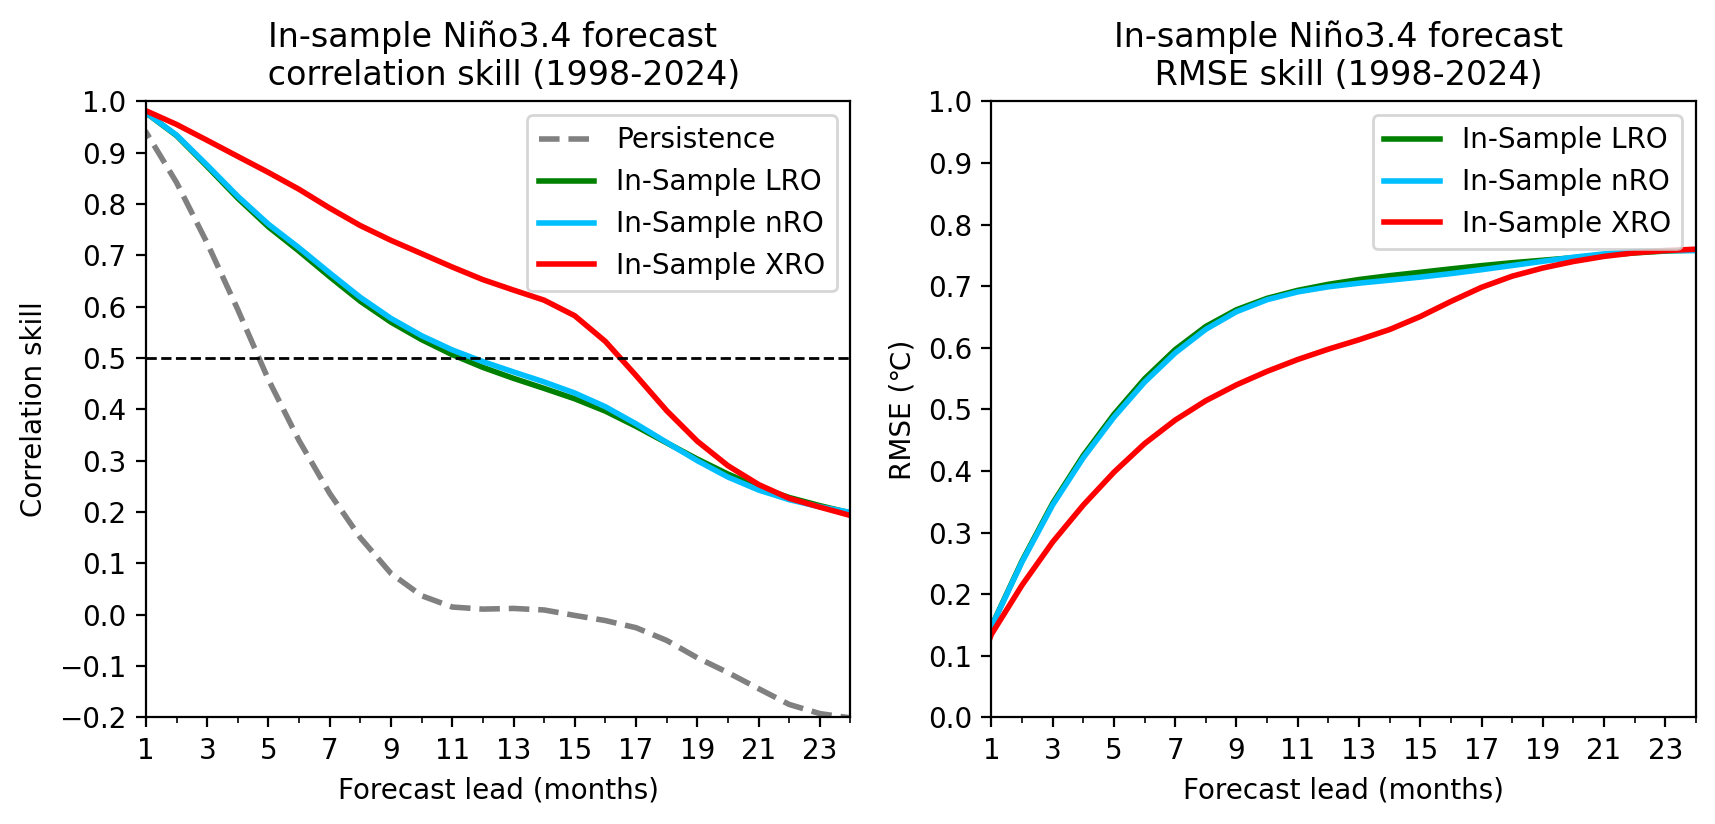

In [13]:
sel_var = 'Nino34'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_Nino34_ds['Nino34'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO', c='green', lw=2)
acc_NRO_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO', c='deepskyblue', lw=2)
acc_XRO_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample Niño3.4 forecast \n correlation skill (1998-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO', c='green', lw=2)
rmse_NRO_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO', c='deepskyblue', lw=2)
rmse_XRO_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO', c='red', lw=2)


ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample Niño3.4 forecast \n RMSE skill (1998-2024)')
ax.legend()


In [14]:
fit_XRO_ann_train = XRO_ann.fit_matrix(obs_XRO_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_ann_insample_fcst = XRO_ann.reforecast(fit_ds=fit_XRO_ann_train, init_ds=obs_XRO_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_ann_insample = calc_forecast_skill(XRO_ann_insample_fcst, obs_XRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

rmse_XRO_ann_insample = calc_forecast_skill(XRO_ann_insample_fcst, obs_XRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

fit_NRO_ann_train = XRO_ann.fit_matrix(obs_NRO_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_ann_insample_fcst = XRO_ann.reforecast(fit_ds=fit_NRO_ann_train, init_ds=obs_NRO_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_ann_insample = calc_forecast_skill(NRO_ann_insample_fcst, obs_NRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))
rmse_NRO_ann_insample = calc_forecast_skill(NRO_ann_insample_fcst, obs_NRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

# fit_LRO_NPP = XRO_ann.fit_matrix(obs_NRO_ds, maskNT=[], maskNH=[])

fit_LRO_ann_train = XRO_ann.fit_matrix(obs_NRO_ds.sel(time=slice_train), maskNT=[], maskNH=[])
LRO_ann_insample_fcst = XRO_ann.reforecast(fit_ds=fit_LRO_ann_train, init_ds=obs_NRO_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_ann_insample = calc_forecast_skill(LRO_ann_insample_fcst, obs_NRO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))
rmse_LRO_ann_insample = calc_forecast_skill(LRO_ann_insample_fcst, obs_NRO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

Y shape: (1, 324)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10 11], inactive=[]
X_active shape: (12, 324), total X shape: (12, 324)
Y shape: (1, 324)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 324), total X shape: (11, 324)
Y shape: (1, 324)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 324), total X shape: (10, 324)
Y shape: (1, 324)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 324), total X shape: (10, 324)
Y shape: (1, 324)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 324), total X shape: (10, 324)
Y shape: (1, 324)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 324), total X shape: (11, 324)
Y shape: (1, 324)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inactive=[]
X_active shape: (10, 324), total X shape: (10, 324)
Y shape: (1, 324)
rank_y: 1
Y=0: active=[0 1 2 3 4 5 6 7 8 9], inacti

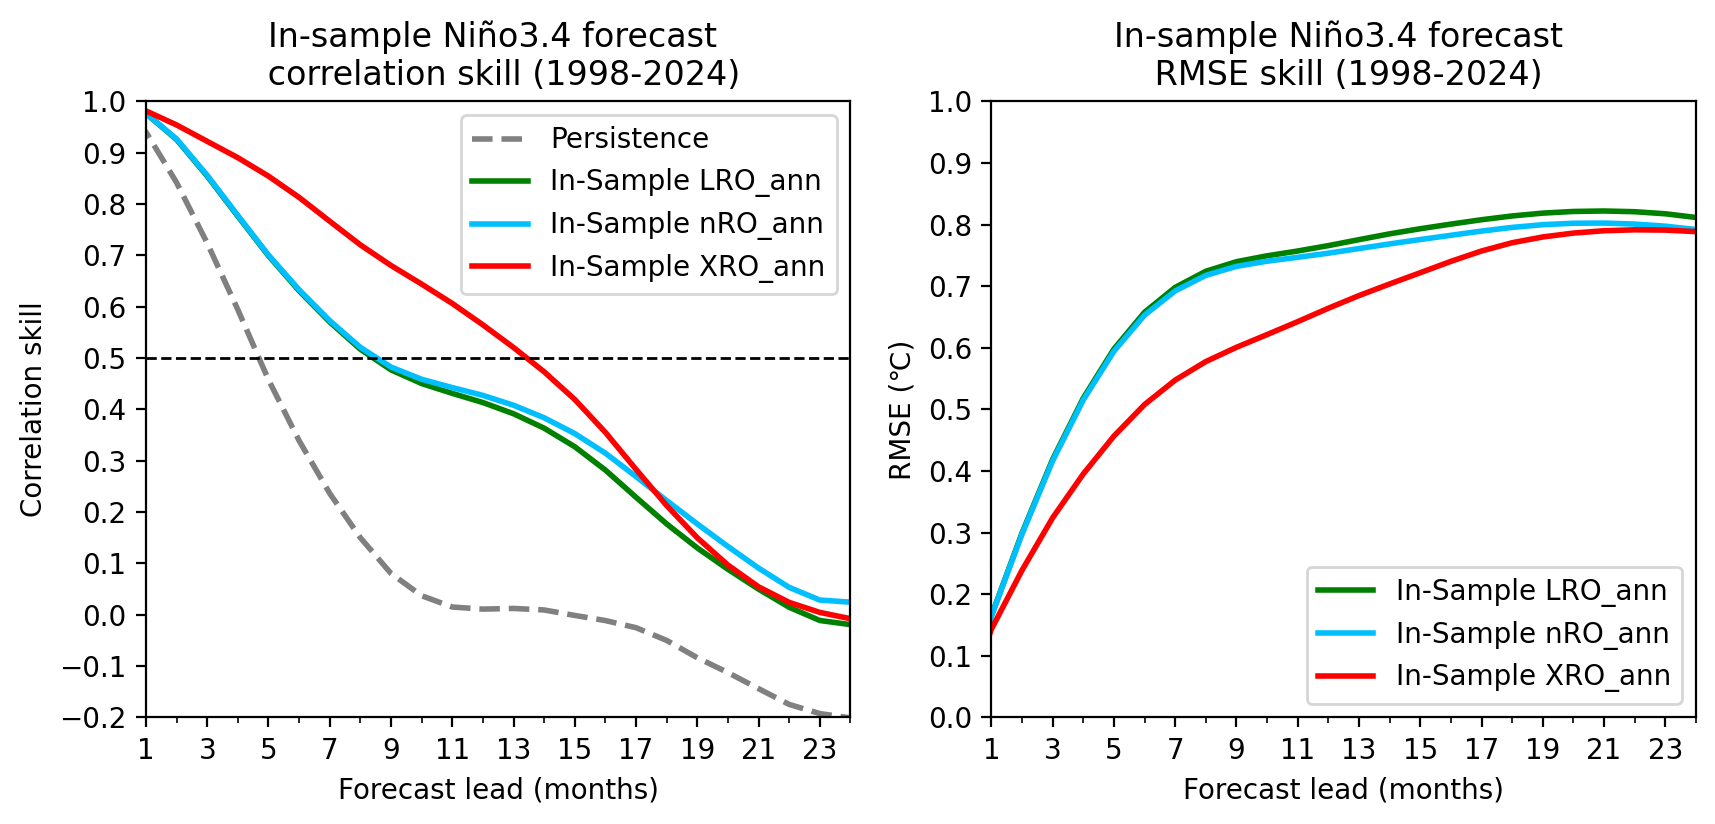

In [15]:
sel_var = 'Nino34'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_Nino34_ds['Nino34'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO_ann', c='green', lw=2)
acc_NRO_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO_ann', c='deepskyblue', lw=2)
acc_XRO_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO_ann', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample Niño3.4 forecast \n correlation skill (1998-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO_ann', c='green', lw=2)
rmse_NRO_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO_ann', c='deepskyblue', lw=2)
rmse_XRO_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO_ann', c='red', lw=2)


ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample Niño3.4 forecast \n RMSE skill (1998-2024)')
ax.legend()


In [17]:

fit_XRO_NPP_train = XRO_NPP_ac1.fit_matrix(obs_XRO_NPP_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_NPP_insample_fcst = XRO_NPP_ac1.reforecast(fit_ds=fit_XRO_NPP_train, init_ds=obs_XRO_NPP_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_NPP_insample = calc_forecast_skill(XRO_NPP_insample_fcst, obs_XRO_NPP_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

rmse_XRO_NPP_insample = calc_forecast_skill(XRO_NPP_insample_fcst, obs_XRO_NPP_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

fit_NRO_NPP_train = XRO_NPP_ac1.fit_matrix(obs_NRO_NPP_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_NPP_insample_fcst = XRO_NPP_ac1.reforecast(fit_ds=fit_NRO_NPP_train, init_ds=obs_NRO_NPP_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_NPP_insample = calc_forecast_skill(NRO_NPP_insample_fcst, obs_NRO_NPP_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))
rmse_NRO_NPP_insample = calc_forecast_skill(NRO_NPP_insample_fcst, obs_NRO_NPP_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

# fit_LRO_NPP = XRO_ac1.fit_matrix(obs_NRO_NPP_ds, maskNT=[], maskNH=[])

fit_LRO_NPP_train = XRO_NPP_ac1.fit_matrix(obs_NRO_NPP_ds.sel(time=slice_train), maskNT=[], maskNH=[])
LRO_NPP_insample_fcst = XRO_NPP_ac1.reforecast(fit_ds=fit_LRO_NPP_train, init_ds=obs_NRO_NPP_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_NPP_insample = calc_forecast_skill(LRO_NPP_insample_fcst, obs_NRO_NPP_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))
rmse_LRO_NPP_insample = calc_forecast_skill(LRO_NPP_insample_fcst, obs_NRO_NPP_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

Y shape: (1, 324)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10 11 12], inactive=[]
X_active shape: (13, 324), total X shape: (13, 324)
Y shape: (1, 324)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10 11], inactive=[]
X_active shape: (12, 324), total X shape: (12, 324)
Y shape: (1, 324)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 324), total X shape: (11, 324)
Y shape: (1, 324)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 324), total X shape: (11, 324)
Y shape: (1, 324)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 324), total X shape: (11, 324)
Y shape: (1, 324)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10 11], inactive=[]
X_active shape: (12, 324), total X shape: (12, 324)
Y shape: (1, 324)
rank_y: 1
Y=0: active=[ 0  1  2  3  4  5  6  7  8  9 10], inactive=[]
X_active shape: (11, 324), total X shape: (11, 324)
Y shape:

In [18]:
fit_XRO_NPP_train

<xarray.Dataset> Size: 157kB
Dimensions:         (ranky: 11, rankx: 11, cycle: 12, ac_rank: 2, cossin: 3,
                     time: 324, nro_form: 5)
Coordinates:
  * rankx           (rankx) int32 44B 1 2 3 4 5 6 7 8 9 10 11
  * cycle           (cycle) float64 96B 0.04167 0.125 0.2083 ... 0.875 0.9583
  * ac_rank         (ac_rank) int32 8B 0 1
  * cossin          (cossin) int32 12B 0 1 2
  * time            (time) float64 3kB 0.04167 0.125 0.2083 ... 26.88 26.96
  * ranky           (ranky) int64 88B 1 2 3 4 5 6 7 8 9 10 11
  * nro_form        (nro_form) <U3 60B 'T2' 'TH' 'T3' 'T2H' 'TH2'
Data variables: (12/31)
    Lac             (ranky, rankx, cycle) float64 12kB -1.91 -2.331 ... -3.192
    Lcomp           (ranky, rankx, cycle, ac_rank) float64 23kB -1.291 ... 1.24
    Lcoef           (ranky, rankx, cossin) float64 3kB -1.291 -0.6185 ... 0.4611
    X               (rankx, time) float64 29kB 2.65 2.132 1.519 ... 10.33 -6.167
    Y               (ranky, time) float64 29kB -6.224 -7.345 ... -198.0 -198.0
    Yfit            (ranky, time) float64 29kB -5.253 -6.847 ... -88.79 -3.517
    ...              ...
    NROT_Lcoef      (nro_form, cossin) float64 120B 0.1965 -0.1141 ... 0.0 0.0
    NROT_Lcomp      (nro_form, cycle, ac_rank) float64 960B 0.1965 ... 0.0
    NROH_Lac        (nro_form, cycle) float64 480B -0.5493 0.38 ... 0.0 0.0
    NROH_Lcoef      (nro_form, cossin) float64 120B 1.817 -2.366 ... 0.0 0.0
    NROH_Lcomp      (nro_form, cycle, ac_rank) float64 960B 1.817 -2.366 ... 0.0
    var_names       (ranky) <U6 264B 'Nino34' 'WWV' 'NPMM' ... 'SASD' 'NPP'

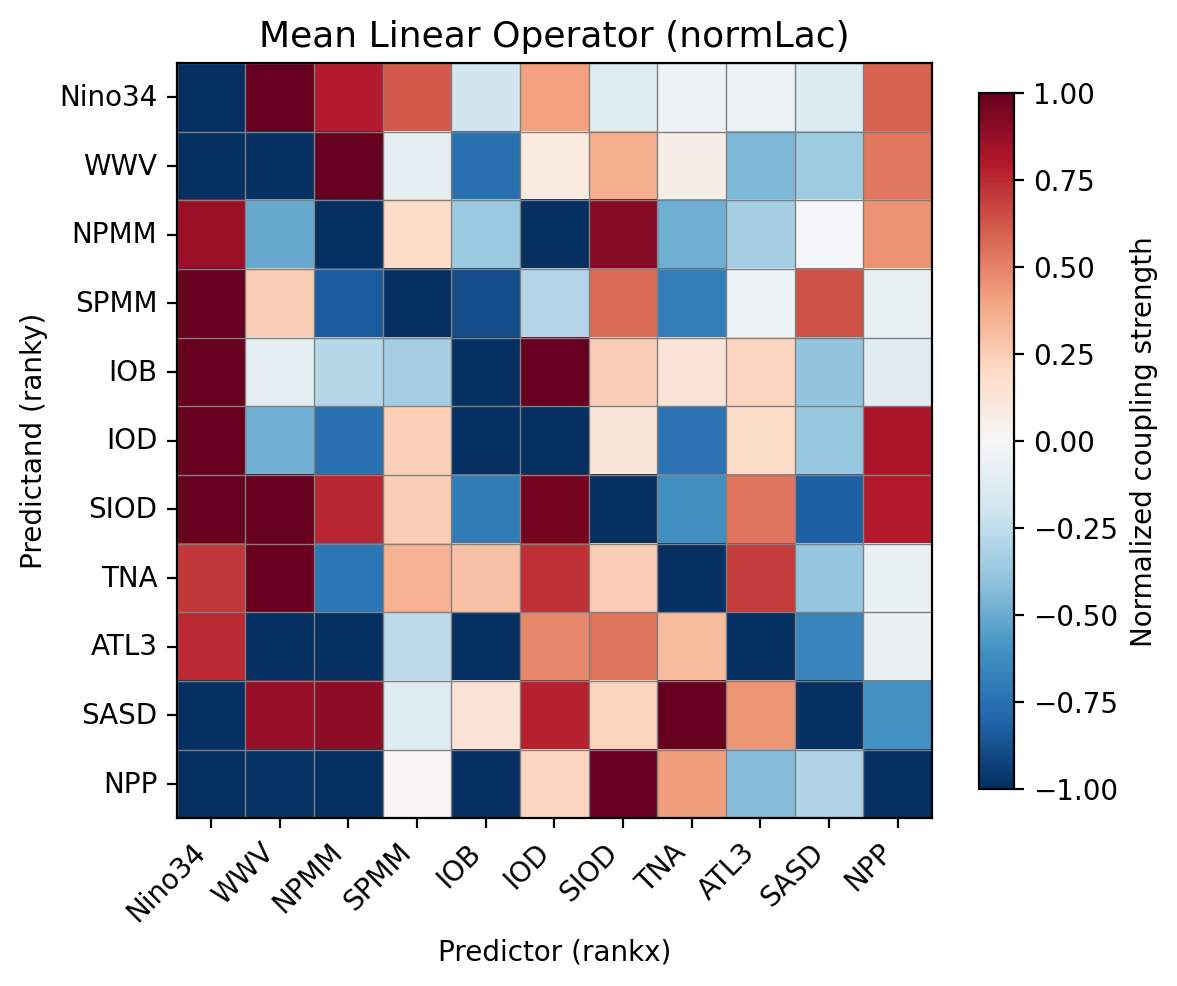

In [21]:
labels = ['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 
           'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD', 'NPP']

fit_ds = fit_XRO_NPP_train

fit_ds = fit_ds.assign_coords(rankx=labels, ranky=labels)
# fit_XRO_NPP_train['normLac'].mean('cycle').plot(cmap='RdBu_r', vmin=-1, vmax=1)
L = fit_ds['normLac'].mean('cycle')

fig, ax = plt.subplots(figsize=(6,5))

# --- use imshow instead of plot for clean cell-centered view ---
im = ax.imshow(L, cmap='RdBu_r', vmin=-1, vmax=1, origin='upper')

# --- ticks and labels (avoid cutting edges) ---
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels, rotation=0, va='center')

# --- add colorbar ---
cbar = plt.colorbar(im, ax=ax, shrink=0.9, label='Normalized coupling strength')

# --- add gridlines for clarity ---
ax.set_xticks(np.arange(-.5, len(labels), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(labels), 1), minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which='minor', bottom=False, left=False)

ax.set_title('Mean Linear Operator (normLac)', fontsize=13)
ax.set_xlabel('Predictor (rankx)')
ax.set_ylabel('Predictand (ranky)')

plt.tight_layout()
plt.show()

In [23]:
ccr_XRO_Nino34_ds = xcorr(obs_XRO_NPP_ds, obs_XRO_NPP_ds['Nino34'], maxlags=36)
ccr_XRO_NPP_ds = xcorr(obs_XRO_NPP_ds, obs_XRO_NPP_ds['NPP'], maxlags=36)

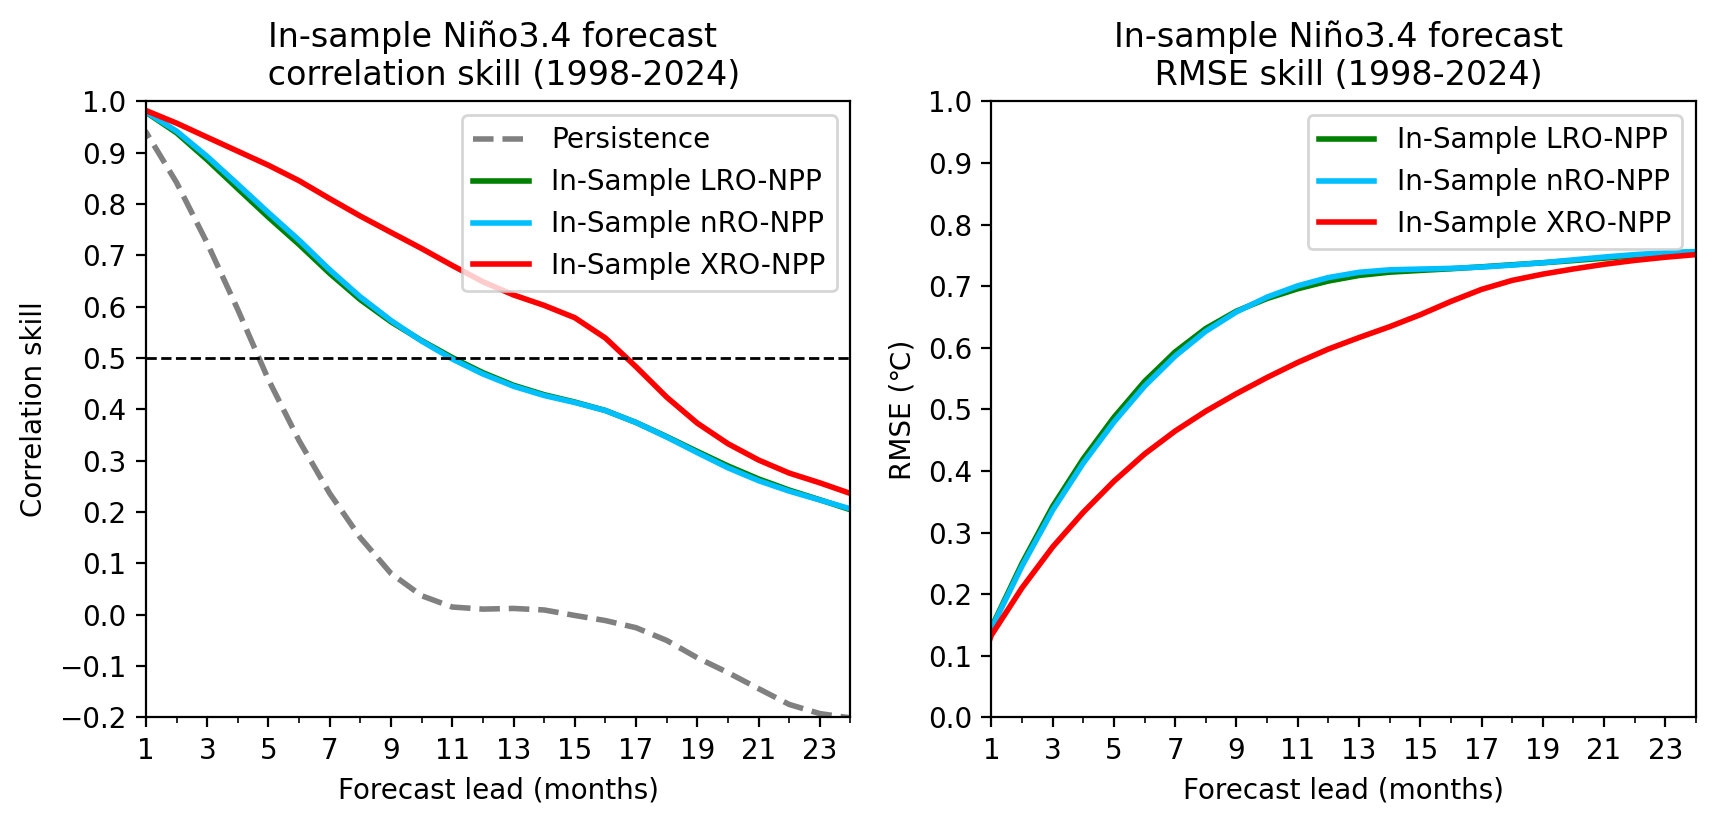

In [24]:
sel_var = 'Nino34'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_Nino34_ds['Nino34'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP', c='green', lw=2)
acc_NRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP', c='deepskyblue', lw=2)
acc_XRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample Niño3.4 forecast \n correlation skill (1998-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP', c='green', lw=2)
rmse_NRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP', c='deepskyblue', lw=2)
rmse_XRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP', c='red', lw=2)


ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample Niño3.4 forecast \n RMSE skill (1998-2024)')
ax.legend()


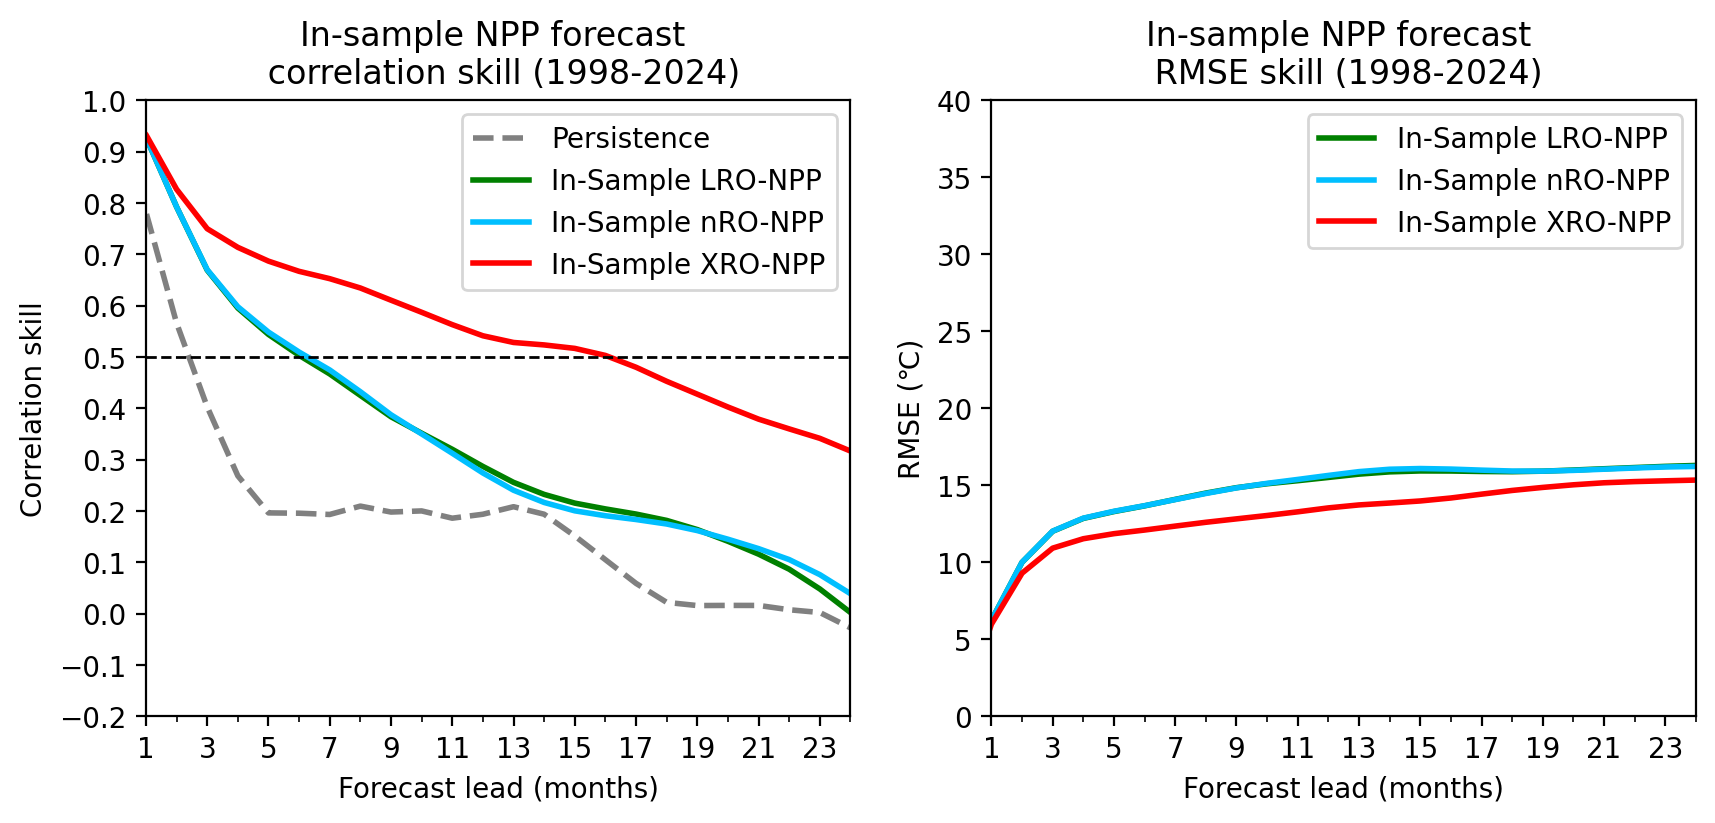

In [25]:
sel_var = 'NPP'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_NPP_ds['NPP'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP', c='green', lw=2)
acc_NRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP', c='deepskyblue', lw=2)
acc_XRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample NPP forecast \n correlation skill (1998-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP', c='green', lw=2)
rmse_NRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP', c='deepskyblue', lw=2)
rmse_XRO_NPP_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP', c='red', lw=2)

ax.set_ylabel('{0} (℃)'.format('RMSE') )

# ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 40.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample NPP forecast \n RMSE skill (1998-2024)')
ax.legend()


In [26]:
XRO_NPP_ann = XRO(ncycle=12, ac_order=0, is_forward=True)


In [27]:

fit_XRO_NPP_ann_train = XRO_NPP_ann.fit_matrix(obs_XRO_NPP_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])
XRO_NPP_ann_insample_fcst = XRO_NPP_ann.reforecast(fit_ds=fit_XRO_NPP_ann_train, init_ds=obs_XRO_NPP_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_NPP_ann_insample = calc_forecast_skill(XRO_NPP_ann_insample_fcst, obs_XRO_NPP_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

rmse_XRO_NPP_ann_insample = calc_forecast_skill(XRO_NPP_ann_insample_fcst, obs_XRO_NPP_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

In [28]:

fit_NRO_NPP_ann_train = XRO_NPP_ann.fit_matrix(obs_NRO_NPP_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_NPP_ann_insample_fcst = XRO_NPP_ann.reforecast(fit_ds=fit_NRO_NPP_ann_train, init_ds=obs_NRO_NPP_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_NPP_ann_insample = calc_forecast_skill(NRO_NPP_ann_insample_fcst, obs_NRO_NPP_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))
rmse_NRO_NPP_ann_insample = calc_forecast_skill(NRO_NPP_ann_insample_fcst, obs_NRO_NPP_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

In [29]:

fit_LRO_NPP_ann_train = XRO_NPP_ann.fit_matrix(obs_NRO_NPP_ds.sel(time=slice_train), maskNT=[], maskNH=[])
LRO_NPP_ann_insample_fcst = XRO_NPP_ann.reforecast(fit_ds=fit_LRO_NPP_ann_train, init_ds=obs_NRO_NPP_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_NPP_ann_insample = calc_forecast_skill(LRO_NPP_ann_insample_fcst, obs_NRO_NPP_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))
rmse_LRO_NPP_ann_insample = calc_forecast_skill(LRO_NPP_ann_insample_fcst, obs_NRO_NPP_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))



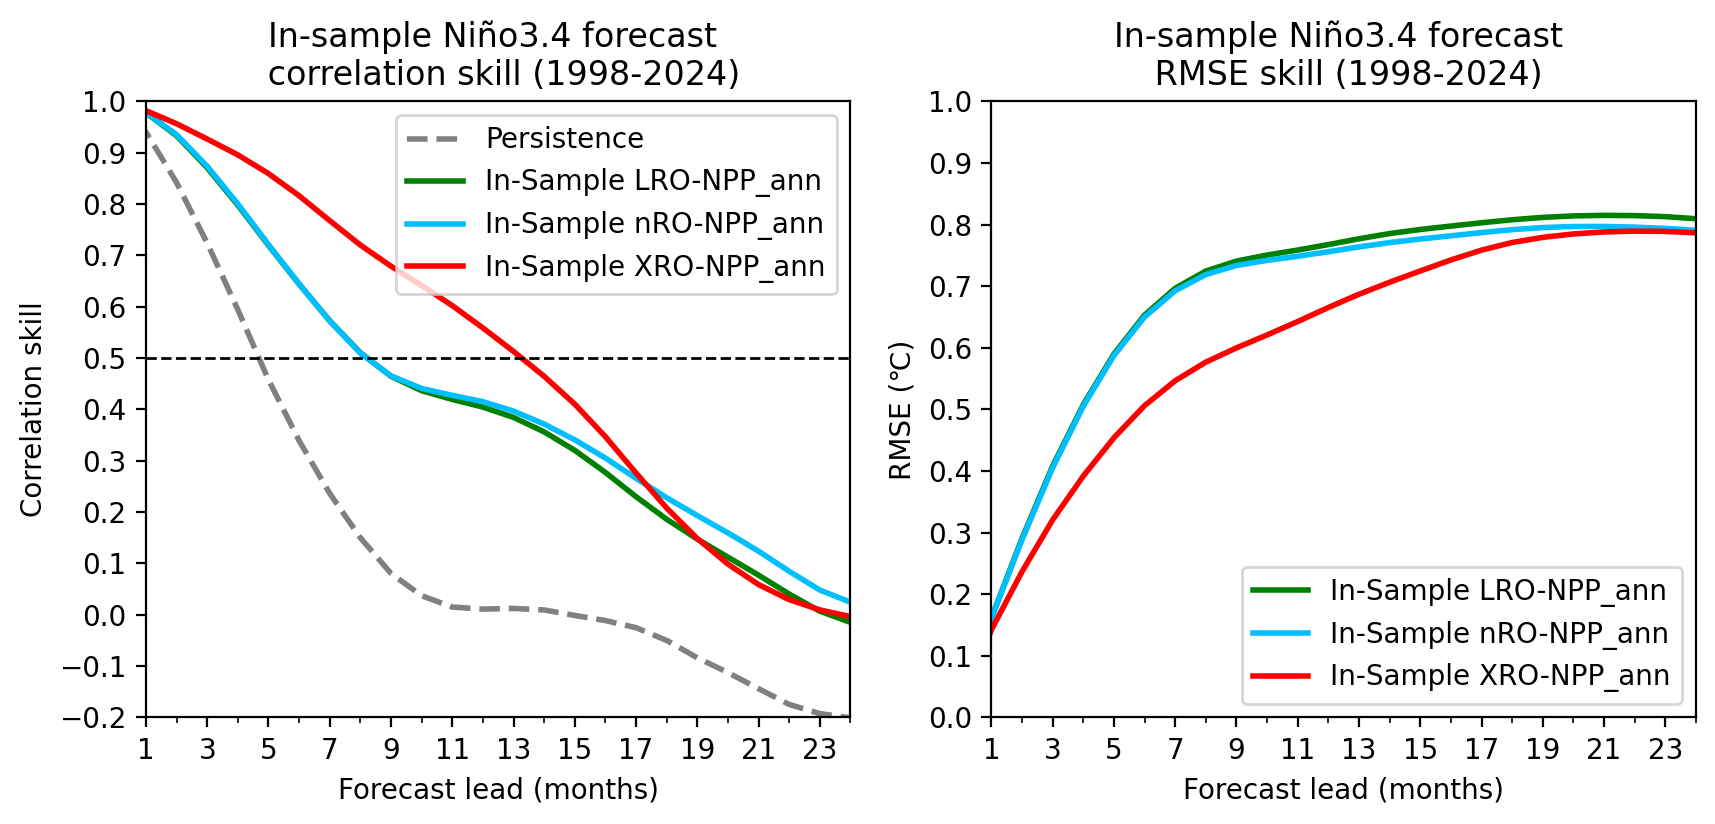

In [30]:
sel_var = 'Nino34'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_Nino34_ds['Nino34'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_NPP_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP_ann', c='green', lw=2)
acc_NRO_NPP_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP_ann', c='deepskyblue', lw=2)
acc_XRO_NPP_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_ann', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample Niño3.4 forecast \n correlation skill (1998-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_NPP_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP_ann', c='green', lw=2)
rmse_NRO_NPP_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP_ann', c='deepskyblue', lw=2)
rmse_XRO_NPP_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_ann', c='red', lw=2)


ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample Niño3.4 forecast \n RMSE skill (1998-2024)')
ax.legend()


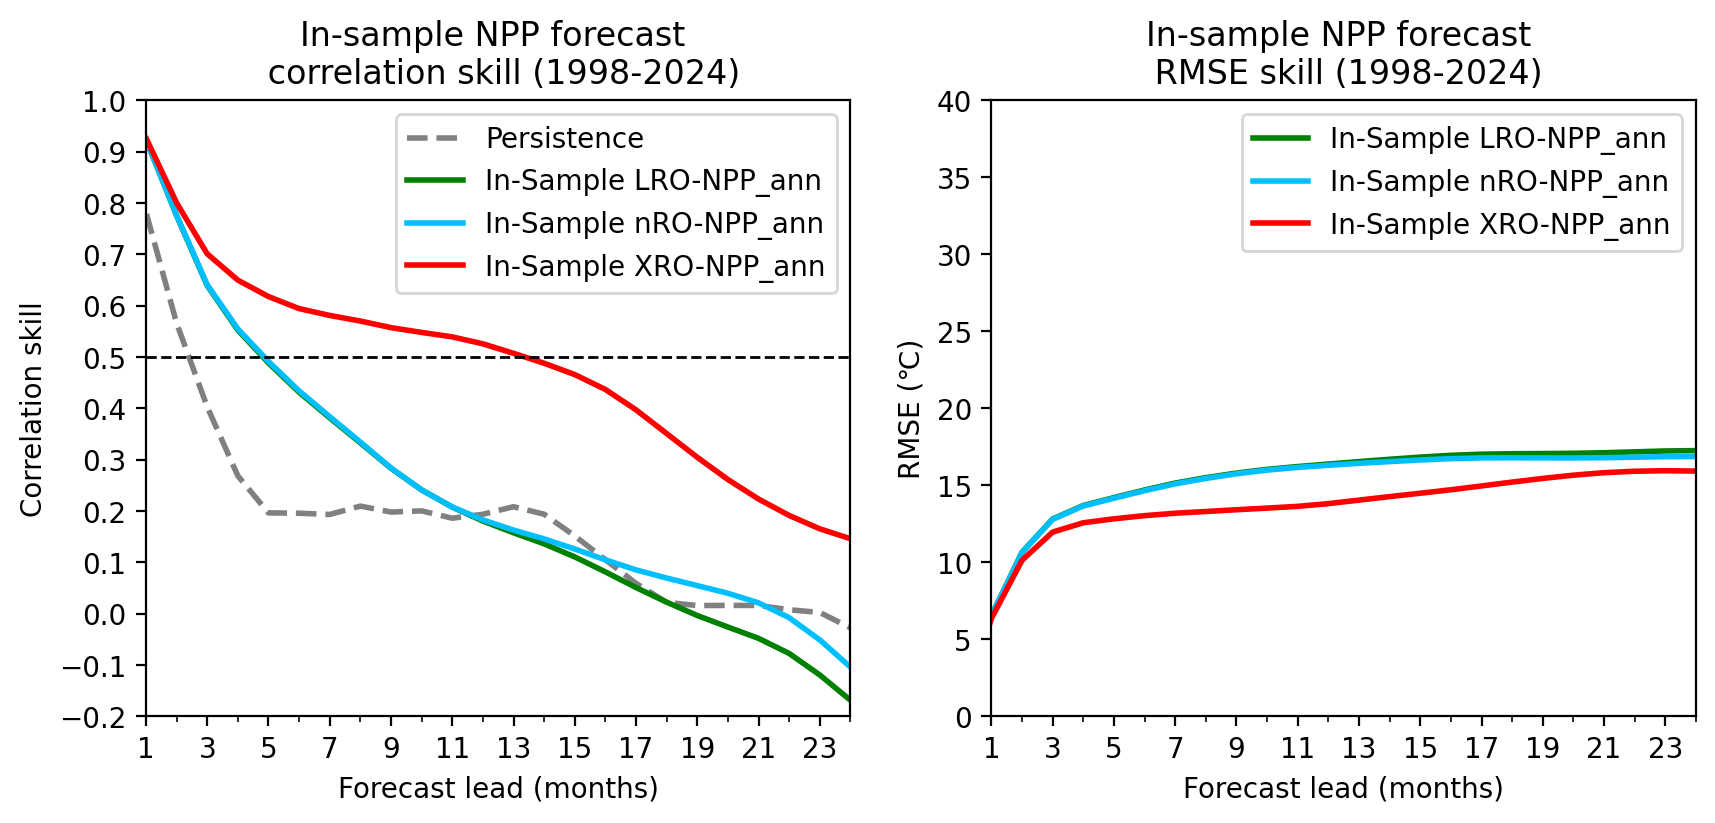

In [31]:
sel_var = 'NPP'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_NPP_ds['NPP'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_NPP_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP_ann', c='green', lw=2)
acc_NRO_NPP_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP_ann', c='deepskyblue', lw=2)
acc_XRO_NPP_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_ann', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample NPP forecast \n correlation skill (1998-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_NPP_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP_ann', c='green', lw=2)
rmse_NRO_NPP_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP_ann', c='deepskyblue', lw=2)
rmse_XRO_NPP_ann_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_ann', c='red', lw=2)

ax.set_ylabel('{0} (℃)'.format('RMSE') )

# ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 40.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample NPP forecast \n RMSE skill (1998-2024)')
ax.legend()


In [32]:
XRO_NPP_ac2 = XRO(ncycle=12, ac_order=2, is_forward=True)


In [33]:

fit_XRO_NPP_ac2_train = XRO_NPP_ac2.fit_matrix(obs_XRO_NPP_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])
XRO_NPP_ac2_insample_fcst = XRO_NPP_ac2.reforecast(fit_ds=fit_XRO_NPP_ac2_train, init_ds=obs_XRO_NPP_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_NPP_ac2_insample = calc_forecast_skill(XRO_NPP_ac2_insample_fcst, obs_XRO_NPP_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

rmse_XRO_NPP_ac2_insample = calc_forecast_skill(XRO_NPP_ac2_insample_fcst, obs_XRO_NPP_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

In [34]:

fit_NRO_NPP_ac2_train = XRO_NPP_ac2.fit_matrix(obs_NRO_NPP_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_NPP_ac2_insample_fcst = XRO_NPP_ac2.reforecast(fit_ds=fit_NRO_NPP_ac2_train, init_ds=obs_NRO_NPP_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_NPP_ac2_insample = calc_forecast_skill(NRO_NPP_ac2_insample_fcst, obs_NRO_NPP_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))
rmse_NRO_NPP_ac2_insample = calc_forecast_skill(NRO_NPP_ac2_insample_fcst, obs_NRO_NPP_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

In [35]:

fit_LRO_NPP_ac2_train = XRO_NPP_ac2.fit_matrix(obs_NRO_NPP_ds.sel(time=slice_train), maskNT=[], maskNH=[])
LRO_NPP_ac2_insample_fcst = XRO_NPP_ac2.reforecast(fit_ds=fit_LRO_NPP_ac2_train, init_ds=obs_NRO_NPP_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_NPP_ac2_insample = calc_forecast_skill(LRO_NPP_ac2_insample_fcst, obs_NRO_NPP_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))
rmse_LRO_NPP_ac2_insample = calc_forecast_skill(LRO_NPP_ac2_insample_fcst, obs_NRO_NPP_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))



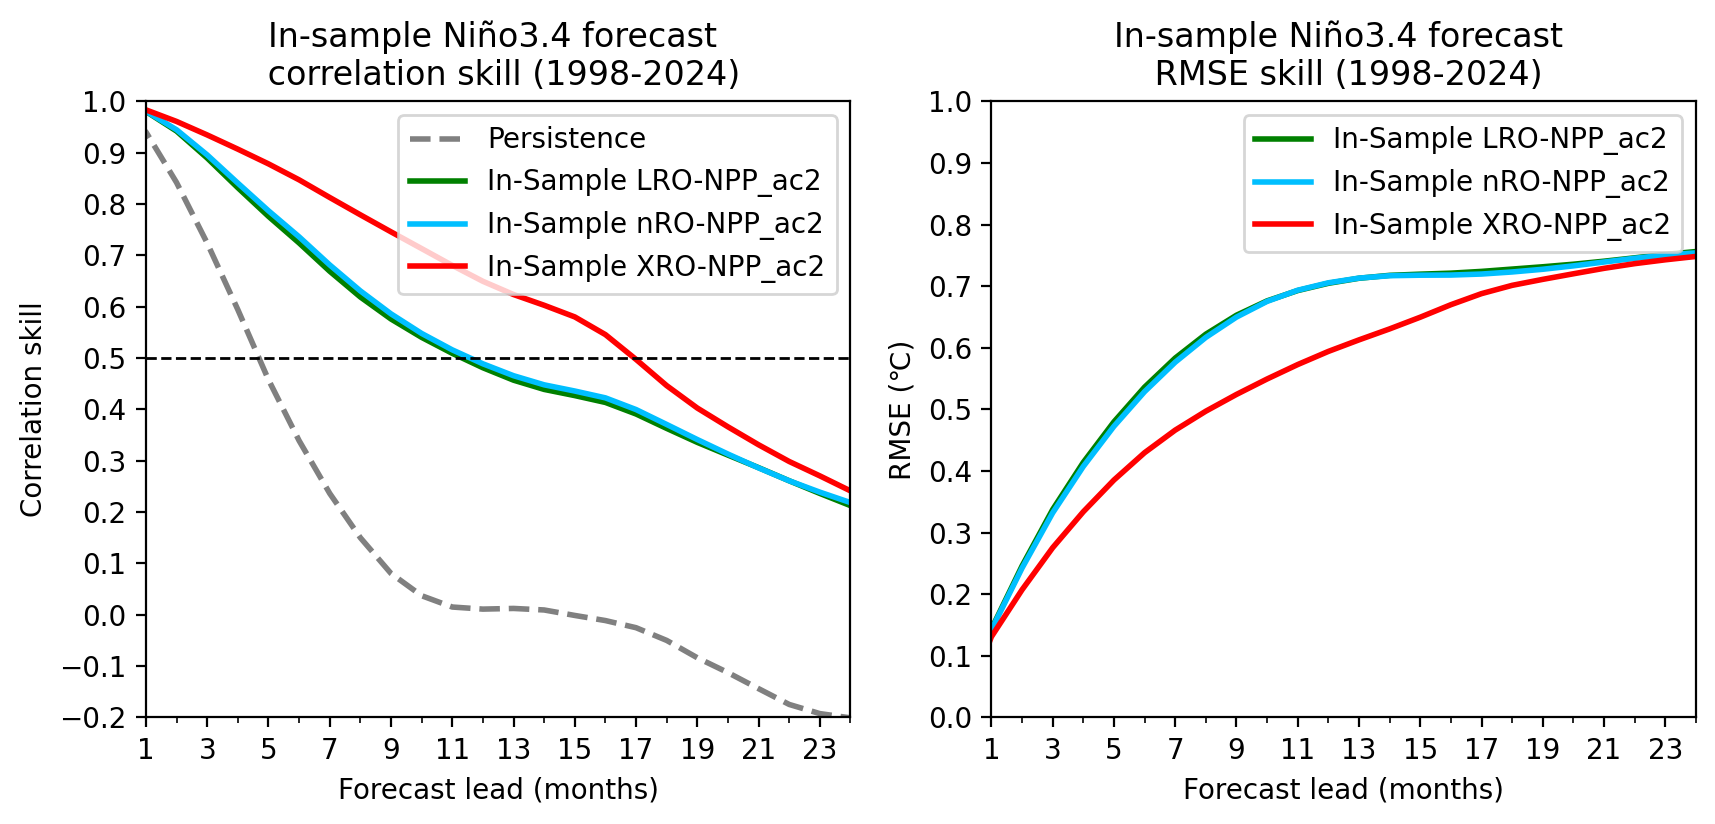

In [36]:
sel_var = 'Nino34'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_Nino34_ds['Nino34'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_NPP_ac2_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP_ac2', c='green', lw=2)
acc_NRO_NPP_ac2_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP_ac2', c='deepskyblue', lw=2)
acc_XRO_NPP_ac2_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_ac2', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample Niño3.4 forecast \n correlation skill (1998-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_NPP_ac2_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP_ac2', c='green', lw=2)
rmse_NRO_NPP_ac2_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP_ac2', c='deepskyblue', lw=2)
rmse_XRO_NPP_ac2_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_ac2', c='red', lw=2)


ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample Niño3.4 forecast \n RMSE skill (1998-2024)')
ax.legend()


Text(0.5, 0, 'Forecast lead (months)')

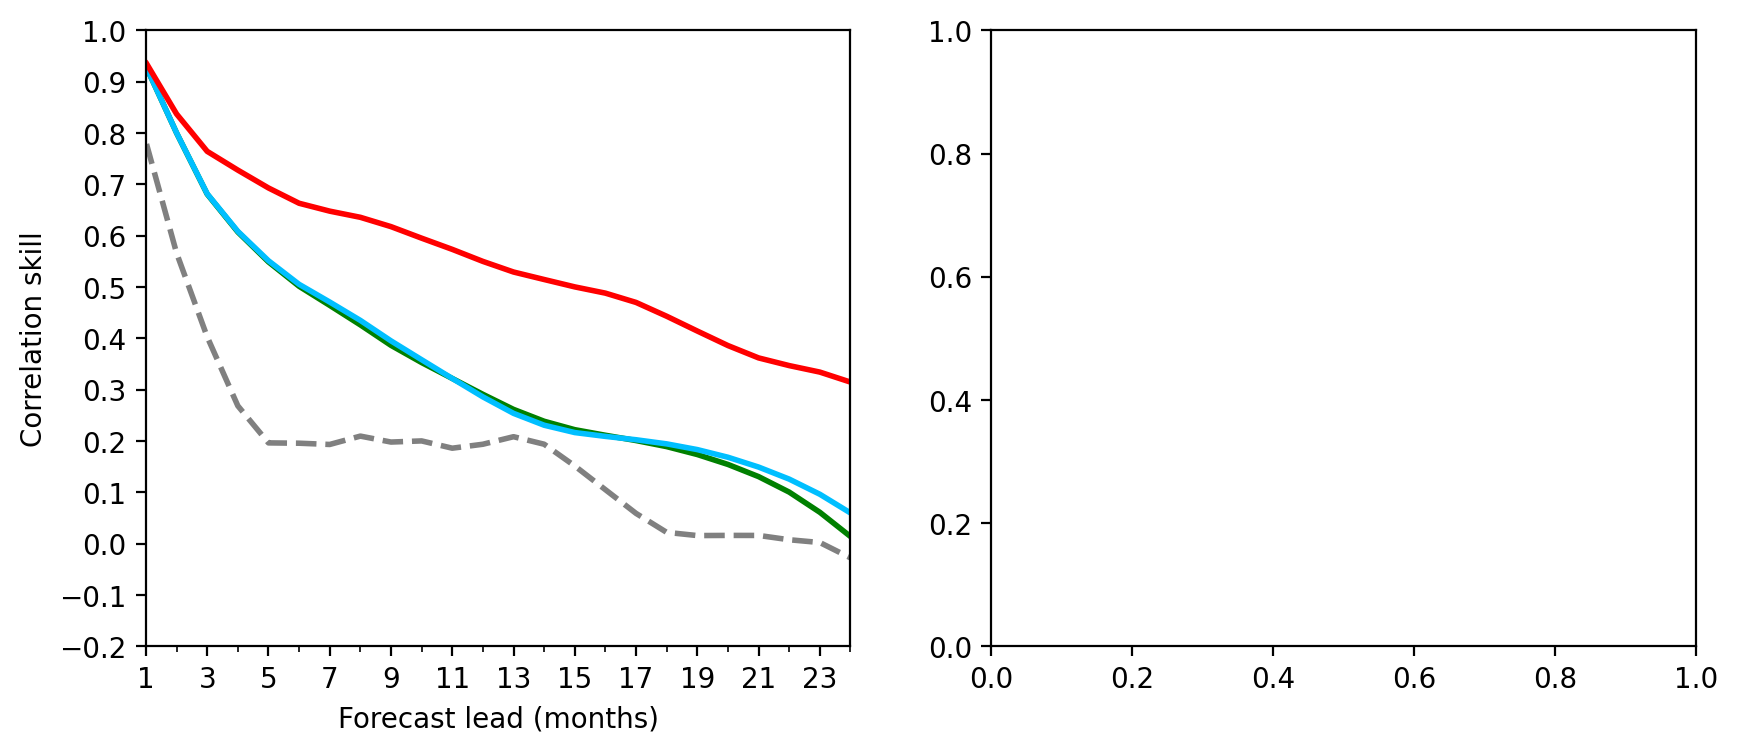

In [37]:
sel_var = 'NPP'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_NPP_ds['NPP'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_NPP_ac2_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP_ac2', c='green', lw=2)
acc_NRO_NPP_ac2_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP_ac2', c='deepskyblue', lw=2)
acc_XRO_NPP_ac2_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP_ac2', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')

In [38]:
XRO_NPP_SST_ac1 = XRO(ncycle=12, ac_order=1, is_forward=True)

fit_XRO_NPP_SST_train = XRO_NPP_SST_ac1.fit_matrix(obs_XRO_NPP_SST_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_NPP_SST_insample_fcst = XRO_NPP_SST_ac1.reforecast(fit_ds=fit_XRO_NPP_SST_train, init_ds=obs_XRO_NPP_SST_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_NPP_SST_insample = calc_forecast_skill(XRO_NPP_SST_insample_fcst, obs_XRO_NPP_SST_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

rmse_XRO_NPP_SST_insample = calc_forecast_skill(XRO_NPP_SST_insample_fcst, obs_XRO_NPP_SST_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

fit_NRO_NPP_SST_train = XRO_NPP_SST_ac1.fit_matrix(obs_NRO_NPP_SST_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_NPP_SST_insample_fcst = XRO_NPP_SST_ac1.reforecast(fit_ds=fit_NRO_NPP_SST_train, init_ds=obs_NRO_NPP_SST_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_NPP_SST_insample = calc_forecast_skill(NRO_NPP_SST_insample_fcst, obs_NRO_NPP_SST_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))
rmse_NRO_NPP_SST_insample = calc_forecast_skill(NRO_NPP_SST_insample_fcst, obs_NRO_NPP_SST_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

# fit_LRO_NPP = XRO_ac1.fit_matrix(obs_NRO_NPP_SST_ds, maskNT=[], maskNH=[])

fit_LRO_NPP_SST_train = XRO_NPP_SST_ac1.fit_matrix(obs_NRO_NPP_SST_ds.sel(time=slice_train), maskNT=[], maskNH=[])
LRO_NPP_SST_insample_fcst = XRO_NPP_SST_ac1.reforecast(fit_ds=fit_LRO_NPP_SST_train, init_ds=obs_NRO_NPP_SST_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_NPP_SST_insample = calc_forecast_skill(LRO_NPP_SST_insample_fcst, obs_NRO_NPP_SST_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))
rmse_LRO_NPP_SST_insample = calc_forecast_skill(LRO_NPP_SST_insample_fcst, obs_NRO_NPP_SST_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

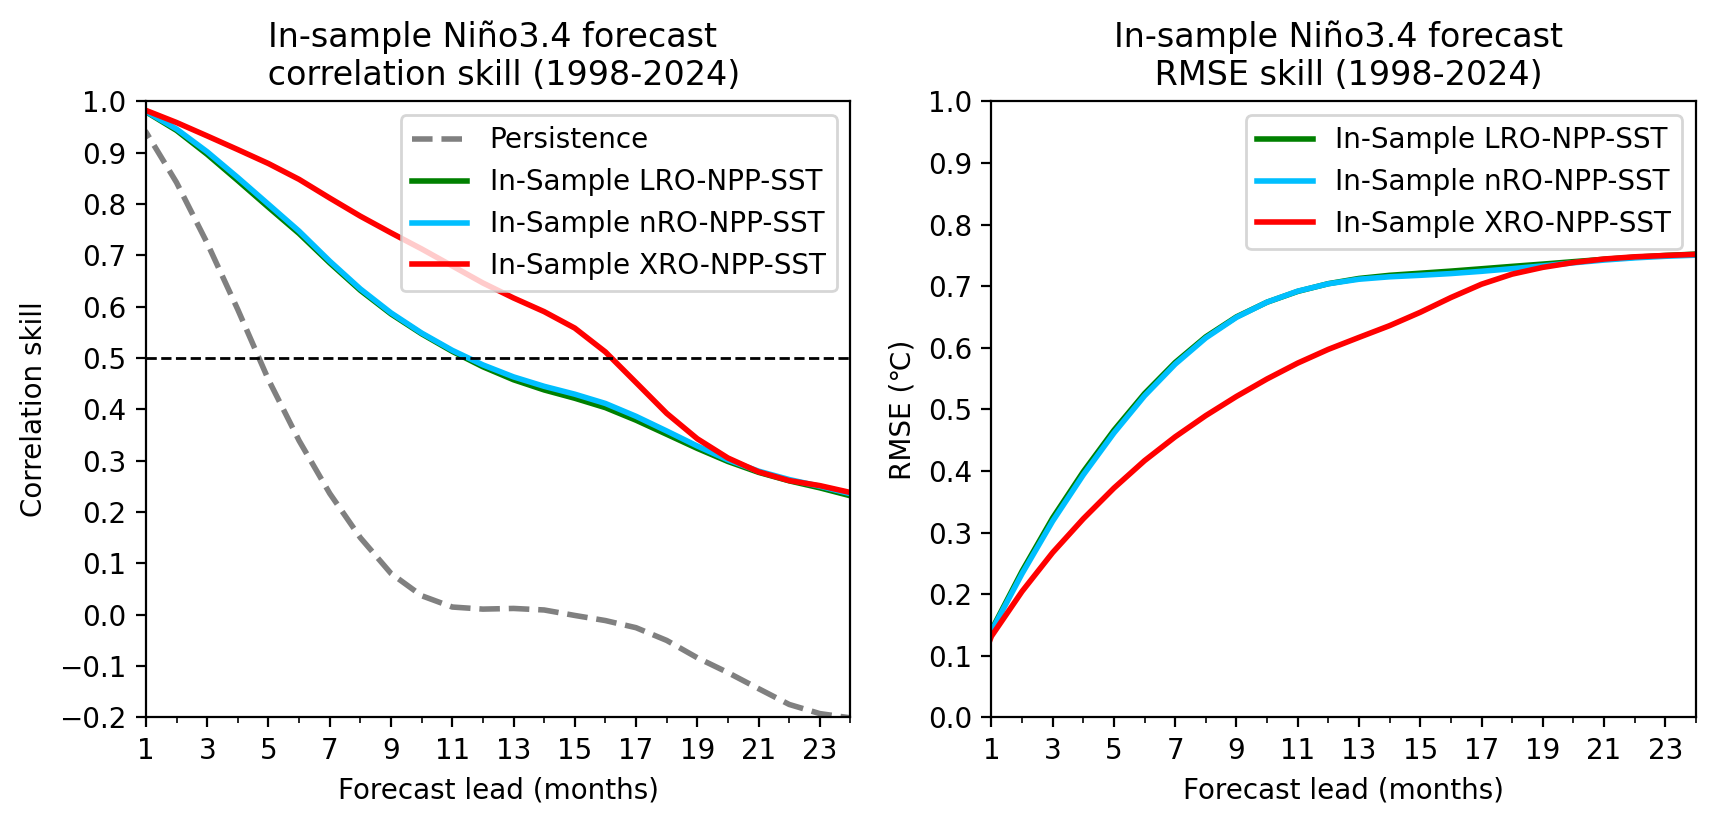

In [39]:
sel_var = 'Nino34'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_Nino34_ds['Nino34'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP-SST', c='green', lw=2)
acc_NRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP-SST', c='deepskyblue', lw=2)
acc_XRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP-SST', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample Niño3.4 forecast \n correlation skill (1998-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP-SST', c='green', lw=2)
rmse_NRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP-SST', c='deepskyblue', lw=2)
rmse_XRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP-SST', c='red', lw=2)


ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample Niño3.4 forecast \n RMSE skill (1998-2024)')
ax.legend()


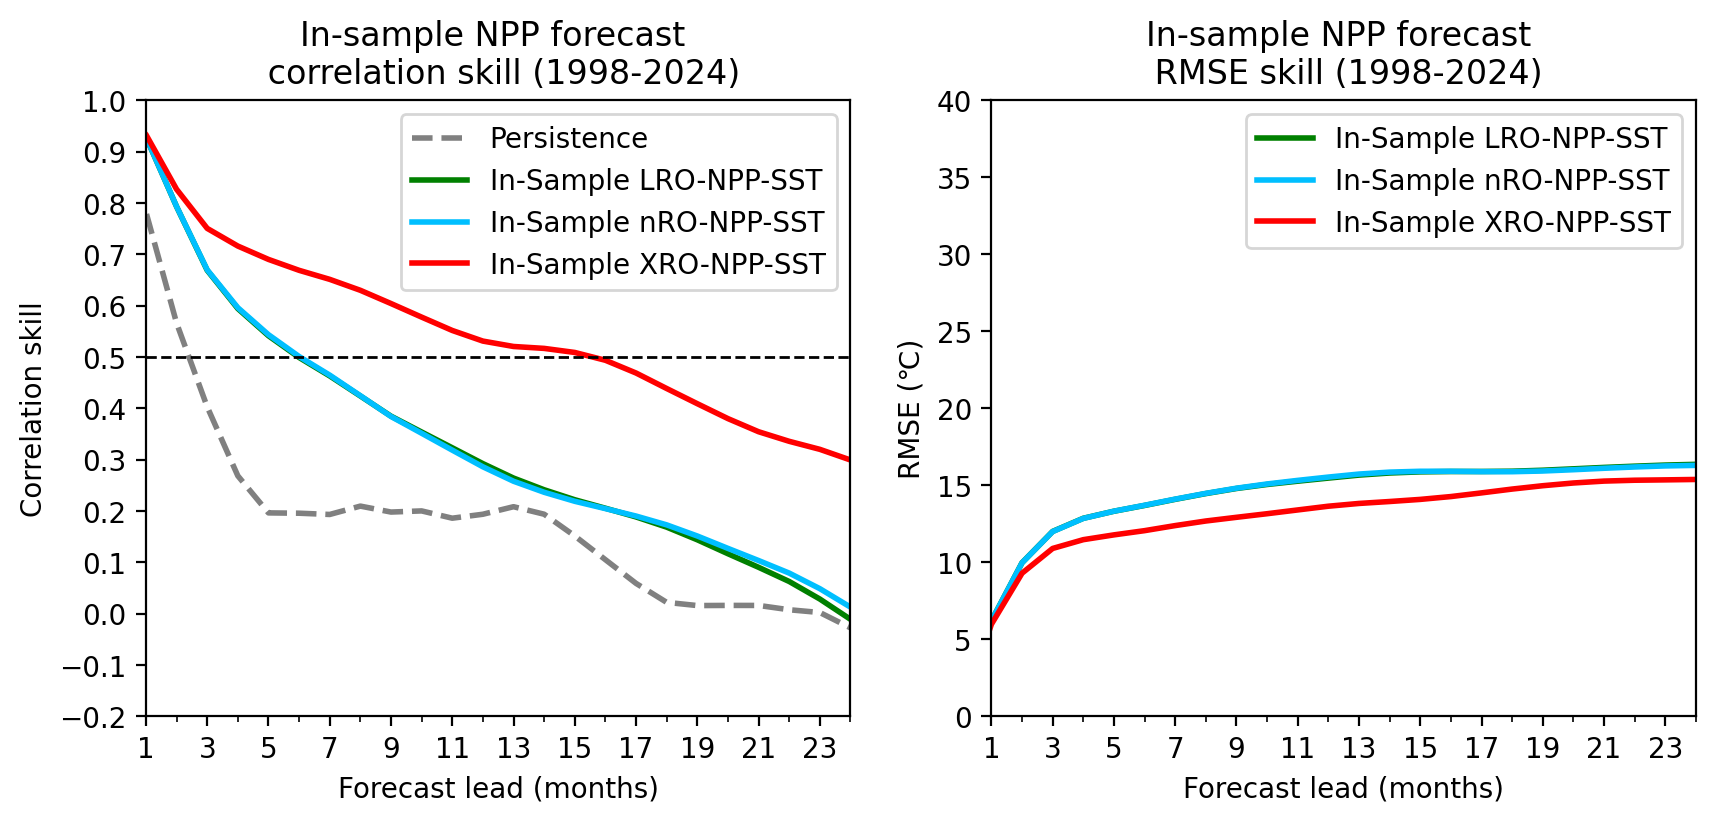

In [68]:
sel_var = 'NPP'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_NPP_ds['NPP'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP-SST', c='green', lw=2)
acc_NRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP-SST', c='deepskyblue', lw=2)
acc_XRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP-SST', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample NPP forecast \n correlation skill (1998-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-NPP-SST', c='green', lw=2)
rmse_NRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-NPP-SST', c='deepskyblue', lw=2)
rmse_XRO_NPP_SST_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-NPP-SST', c='red', lw=2)


ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 40.01, step=5))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 40.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample NPP forecast \n RMSE skill (1998-2024)')
ax.legend()


In [41]:
slice_train2 = slice('1998-01', '2023-12')

XRO_ALL_ac1 = XRO(ncycle=12, ac_order=1, is_forward=True)

fit_XRO_ALL_train = XRO_ALL_ac1.fit_matrix(obs_XRO_ALL_ds.sel(time=slice_train2), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_ALL_insample_fcst = XRO_ALL_ac1.reforecast(fit_ds=fit_XRO_ALL_train, init_ds=obs_XRO_ALL_ds.sel(time=slice_verif), n_month=24, ncopy=1, noise_type='zero')

acc_XRO_ALL_insample = calc_forecast_skill(XRO_ALL_insample_fcst, obs_XRO_ALL_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

rmse_XRO_ALL_insample = calc_forecast_skill(XRO_ALL_insample_fcst, obs_XRO_ALL_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

fit_NRO_ALL_train = XRO_ALL_ac1.fit_matrix(obs_NRO_ALL_ds.sel(time=slice_train2), maskNT=['T2'], maskNH=['T2'])
NRO_ALL_insample_fcst = XRO_ALL_ac1.reforecast(fit_ds=fit_NRO_ALL_train, init_ds=obs_NRO_ALL_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_NRO_ALL_insample = calc_forecast_skill(NRO_ALL_insample_fcst, obs_NRO_ALL_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))
rmse_NRO_ALL_insample = calc_forecast_skill(NRO_ALL_insample_fcst, obs_NRO_ALL_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

# fit_LRO_NPP = XRO_ac1.fit_matrix(obs_NRO_ALL_ds, maskNT=[], maskNH=[])

fit_LRO_ALL_train = XRO_ALL_ac1.fit_matrix(obs_NRO_ALL_ds.sel(time=slice_train2), maskNT=[], maskNH=[])
LRO_ALL_insample_fcst = XRO_ALL_ac1.reforecast(fit_ds=fit_LRO_ALL_train, init_ds=obs_NRO_ALL_ds.sel(time=slice_verif), 
                                          n_month=24, ncopy=1, noise_type='zero')

acc_LRO_ALL_insample = calc_forecast_skill(LRO_ALL_insample_fcst, obs_NRO_ALL_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))
rmse_LRO_ALL_insample = calc_forecast_skill(LRO_ALL_insample_fcst, obs_NRO_ALL_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=True, verify_periods=slice('1998-01', '2024-12'))

In [ ]:
labels = ['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 
           'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD', 'NPP']

fit_ds = fit_XRO_ALL_train

fit_ds = fit_ds.assign_coords(rankx=labels, ranky=labels)
# fit_XRO_NPP_train['normLac'].mean('cycle').plot(cmap='RdBu_r', vmin=-1, vmax=1)
L = fit_ds['normLac'].mean('cycle')

fig, ax = plt.subplots(figsize=(6,5))

# --- use imshow instead of plot for clean cell-centered view ---
im = ax.imshow(L, cmap='RdBu_r', vmin=-1, vmax=1, origin='upper')

# --- ticks and labels (avoid cutting edges) ---
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels, rotation=0, va='center')

# --- add colorbar ---
cbar = plt.colorbar(im, ax=ax, shrink=0.9, label='Normalized coupling strength')

# --- add gridlines for clarity ---
ax.set_xticks(np.arange(-.5, len(labels), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(labels), 1), minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which='minor', bottom=False, left=False)

ax.set_title('Mean Linear Operator (normLac)', fontsize=13)
ax.set_xlabel('Predictor (rankx)')
ax.set_ylabel('Predictand (ranky)')

plt.tight_layout()
plt.show()

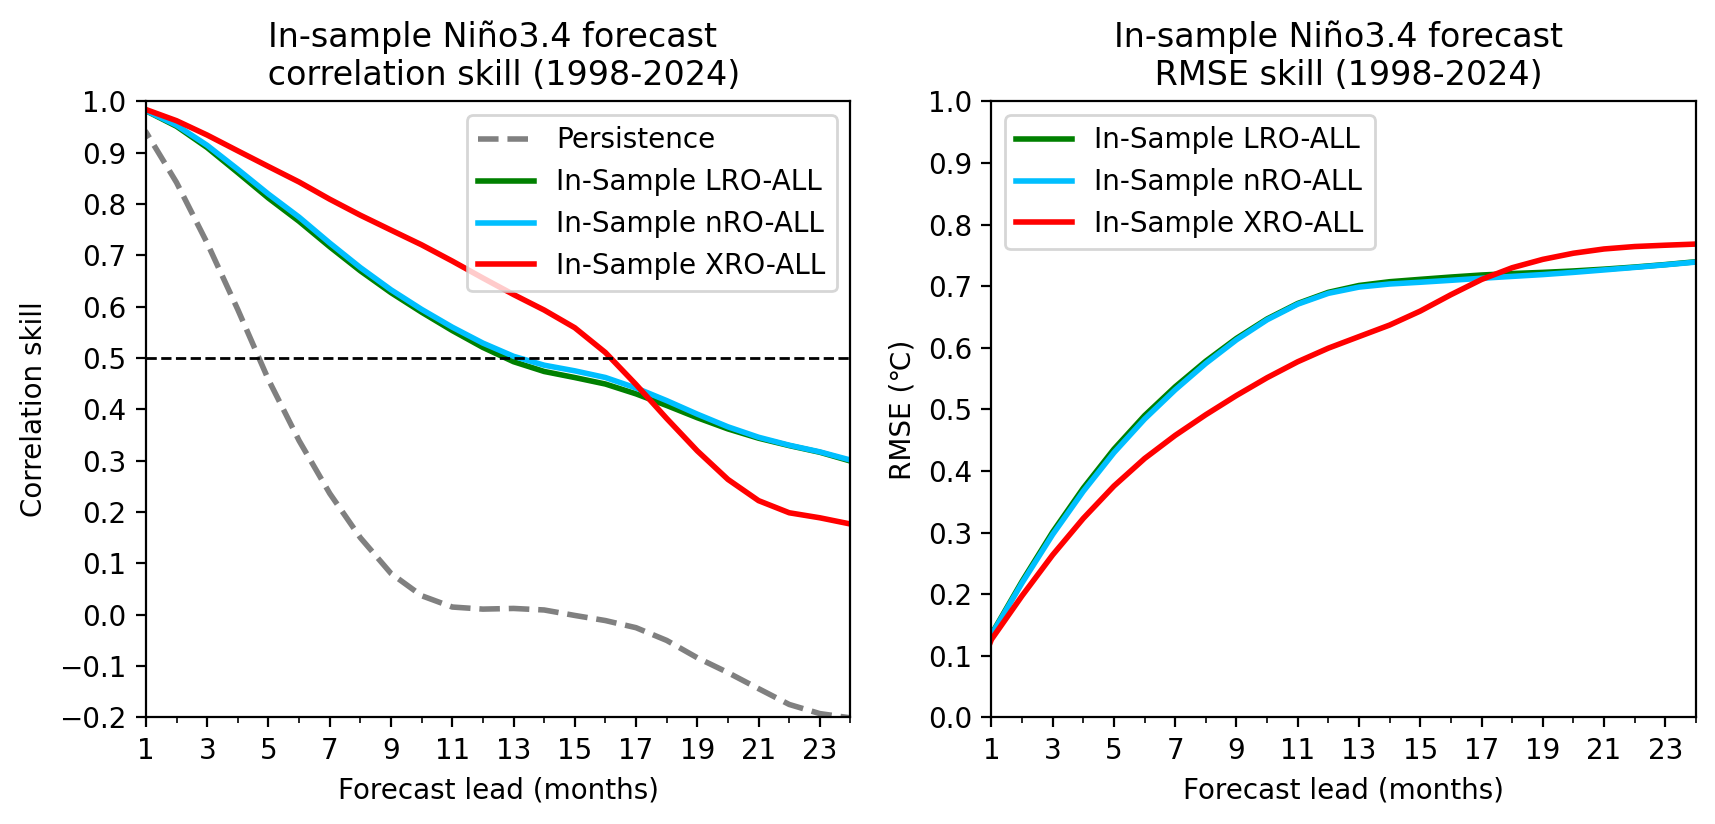

In [42]:
sel_var = 'Nino34'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_Nino34_ds['Nino34'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-ALL', c='green', lw=2)
acc_NRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-ALL', c='deepskyblue', lw=2)
acc_XRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-ALL', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample Niño3.4 forecast \n correlation skill (1998-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-ALL', c='green', lw=2)
rmse_NRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-ALL', c='deepskyblue', lw=2)
rmse_XRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-ALL', c='red', lw=2)


ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample Niño3.4 forecast \n RMSE skill (1998-2024)')
ax.legend()


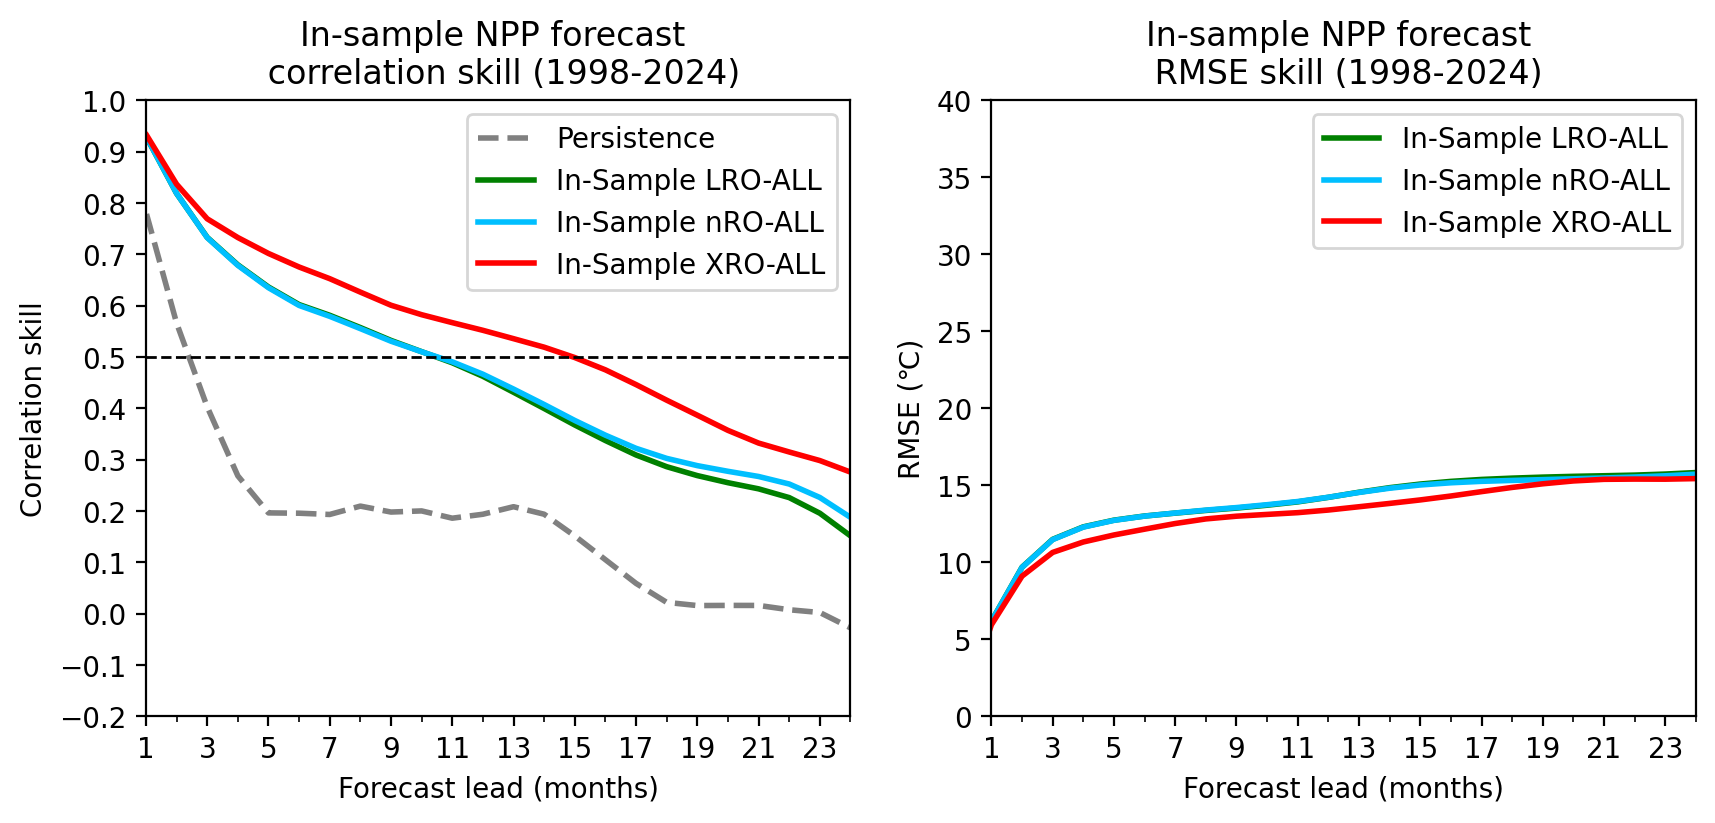

In [69]:
sel_var = 'NPP'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ccr_XRO_NPP_ds['NPP'].sel(lag=slice(0,24)).plot(ax=ax, label='Persistence', c='gray', lw=2, ls='--')
acc_LRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-ALL', c='green', lw=2)
acc_NRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-ALL', c='deepskyblue', lw=2)
acc_XRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-ALL', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(-0.2, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([-0.2, 1.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample NPP forecast \n correlation skill (1998-2024)')
ax.legend()

ax = axes[1]
rmse_LRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample LRO-ALL', c='green', lw=2)
rmse_NRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample nRO-ALL', c='deepskyblue', lw=2)
rmse_XRO_ALL_insample[sel_var].mean(dim='month').plot(ax=ax, label='In-Sample XRO-ALL', c='red', lw=2)


ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 40.01, step=5))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 40.])
ax.set_xlim([1., 24])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample NPP forecast \n RMSE skill (1998-2024)')
ax.legend()


### 5.2 Compare between XRO-NPP and nRO-NPP, ensemble simulations

In [44]:
XRO_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_XRO_train, 
                                              init_ds=obs_XRO_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')
NRO_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_NRO_train, 
                                              init_ds=obs_NRO_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')
LRO_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_LRO_train, 
                                              init_ds=obs_NRO_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')

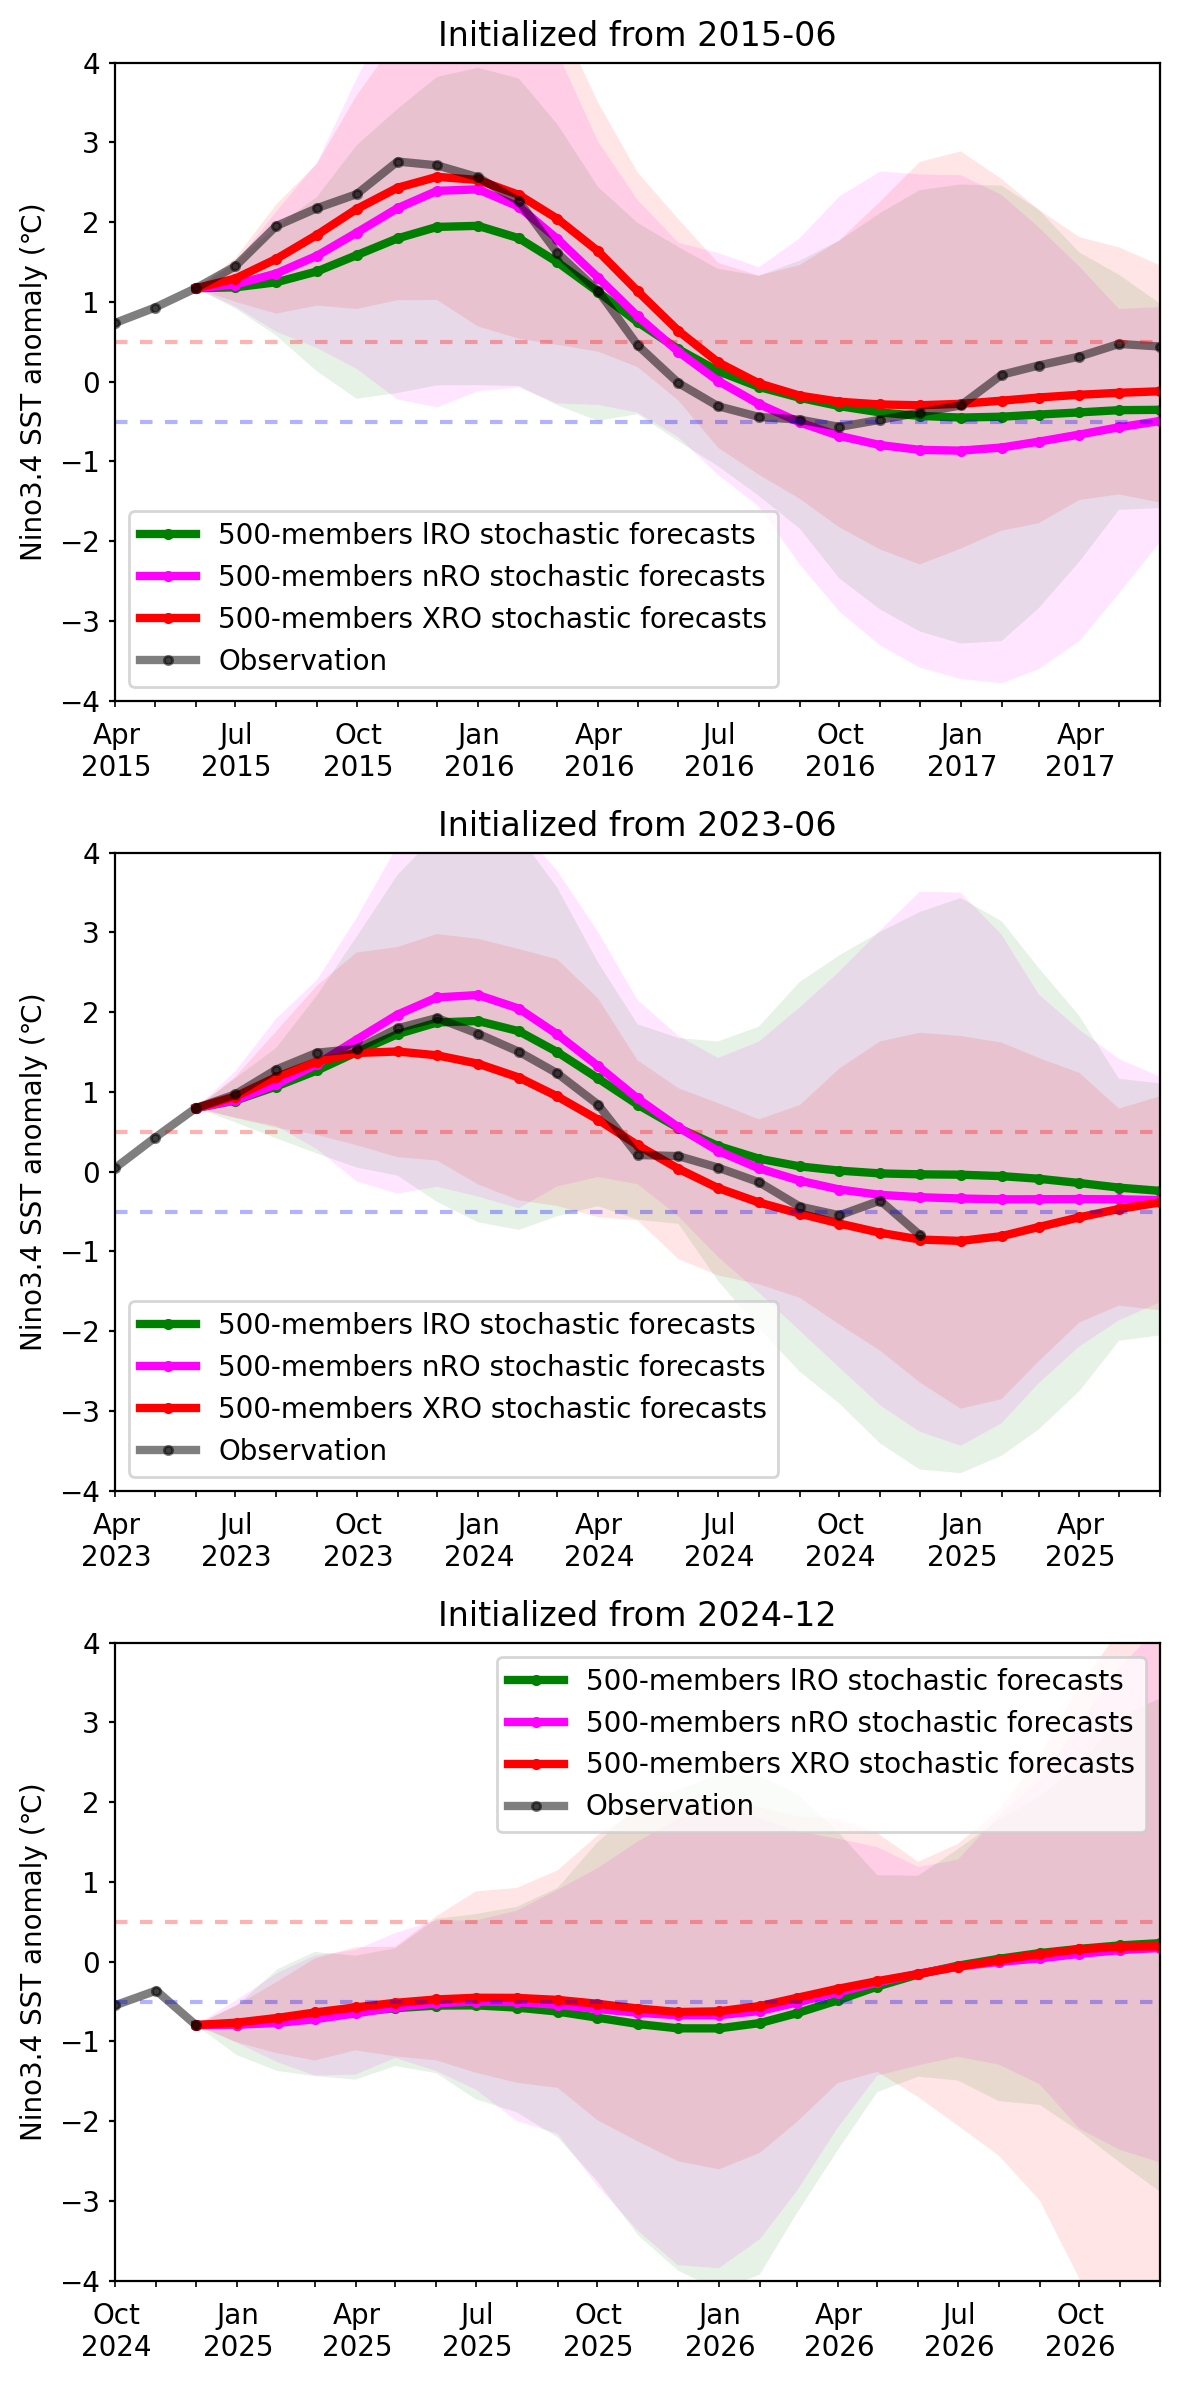

In [45]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_NPP_insample_fcst['Nino34'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = obs_XRO_NPP_ds['Nino34'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty

    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([-4., 4.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()

In [46]:
XRO_ann_insample_fcst_ens = XRO_ann.reforecast(fit_ds=fit_XRO_ann_train, 
                                              init_ds=obs_XRO_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')
NRO_ann_insample_fcst_ens = XRO_ann.reforecast(fit_ds=fit_NRO_ann_train, 
                                              init_ds=obs_NRO_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')
LRO_ann_insample_fcst_ens = XRO_ann.reforecast(fit_ds=fit_LRO_ann_train, 
                                              init_ds=obs_NRO_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')

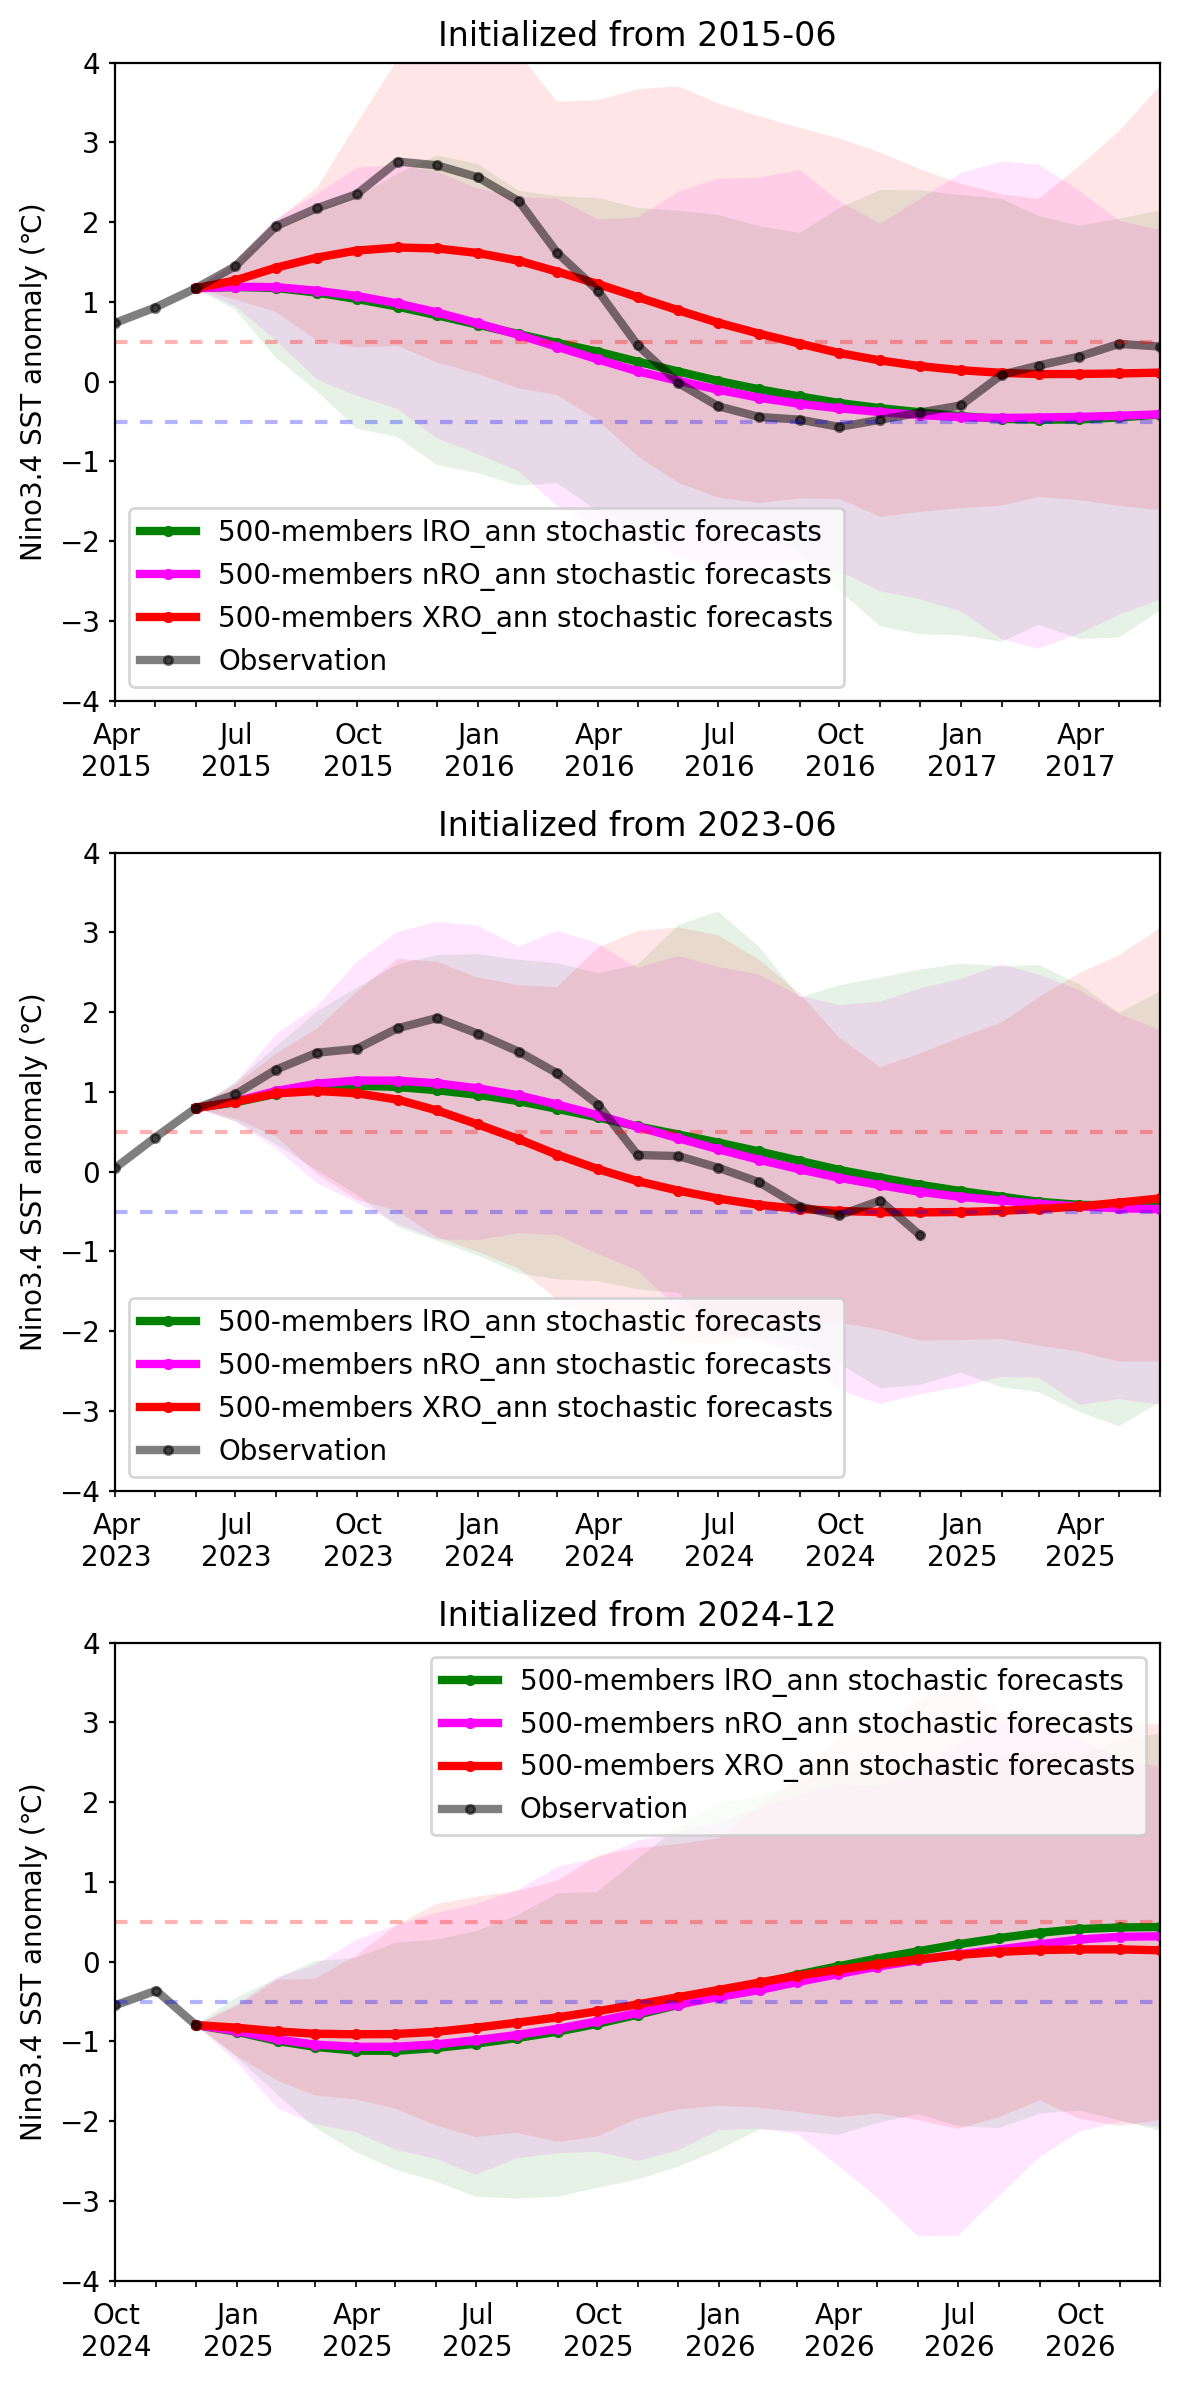

In [47]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_ann_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_NPP_insample_fcst['Nino34'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_ann_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_ann_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = obs_XRO_NPP_ds['Nino34'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty

    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO_ann stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO_ann stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO_ann stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([-4., 4.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()

In [48]:
XRO_NPP_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_XRO_NPP_train, 
                                              init_ds=obs_XRO_NPP_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')
NRO_NPP_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_NRO_NPP_train, 
                                              init_ds=obs_NRO_NPP_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')
LRO_NPP_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_LRO_NPP_train, 
                                              init_ds=obs_NRO_NPP_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')

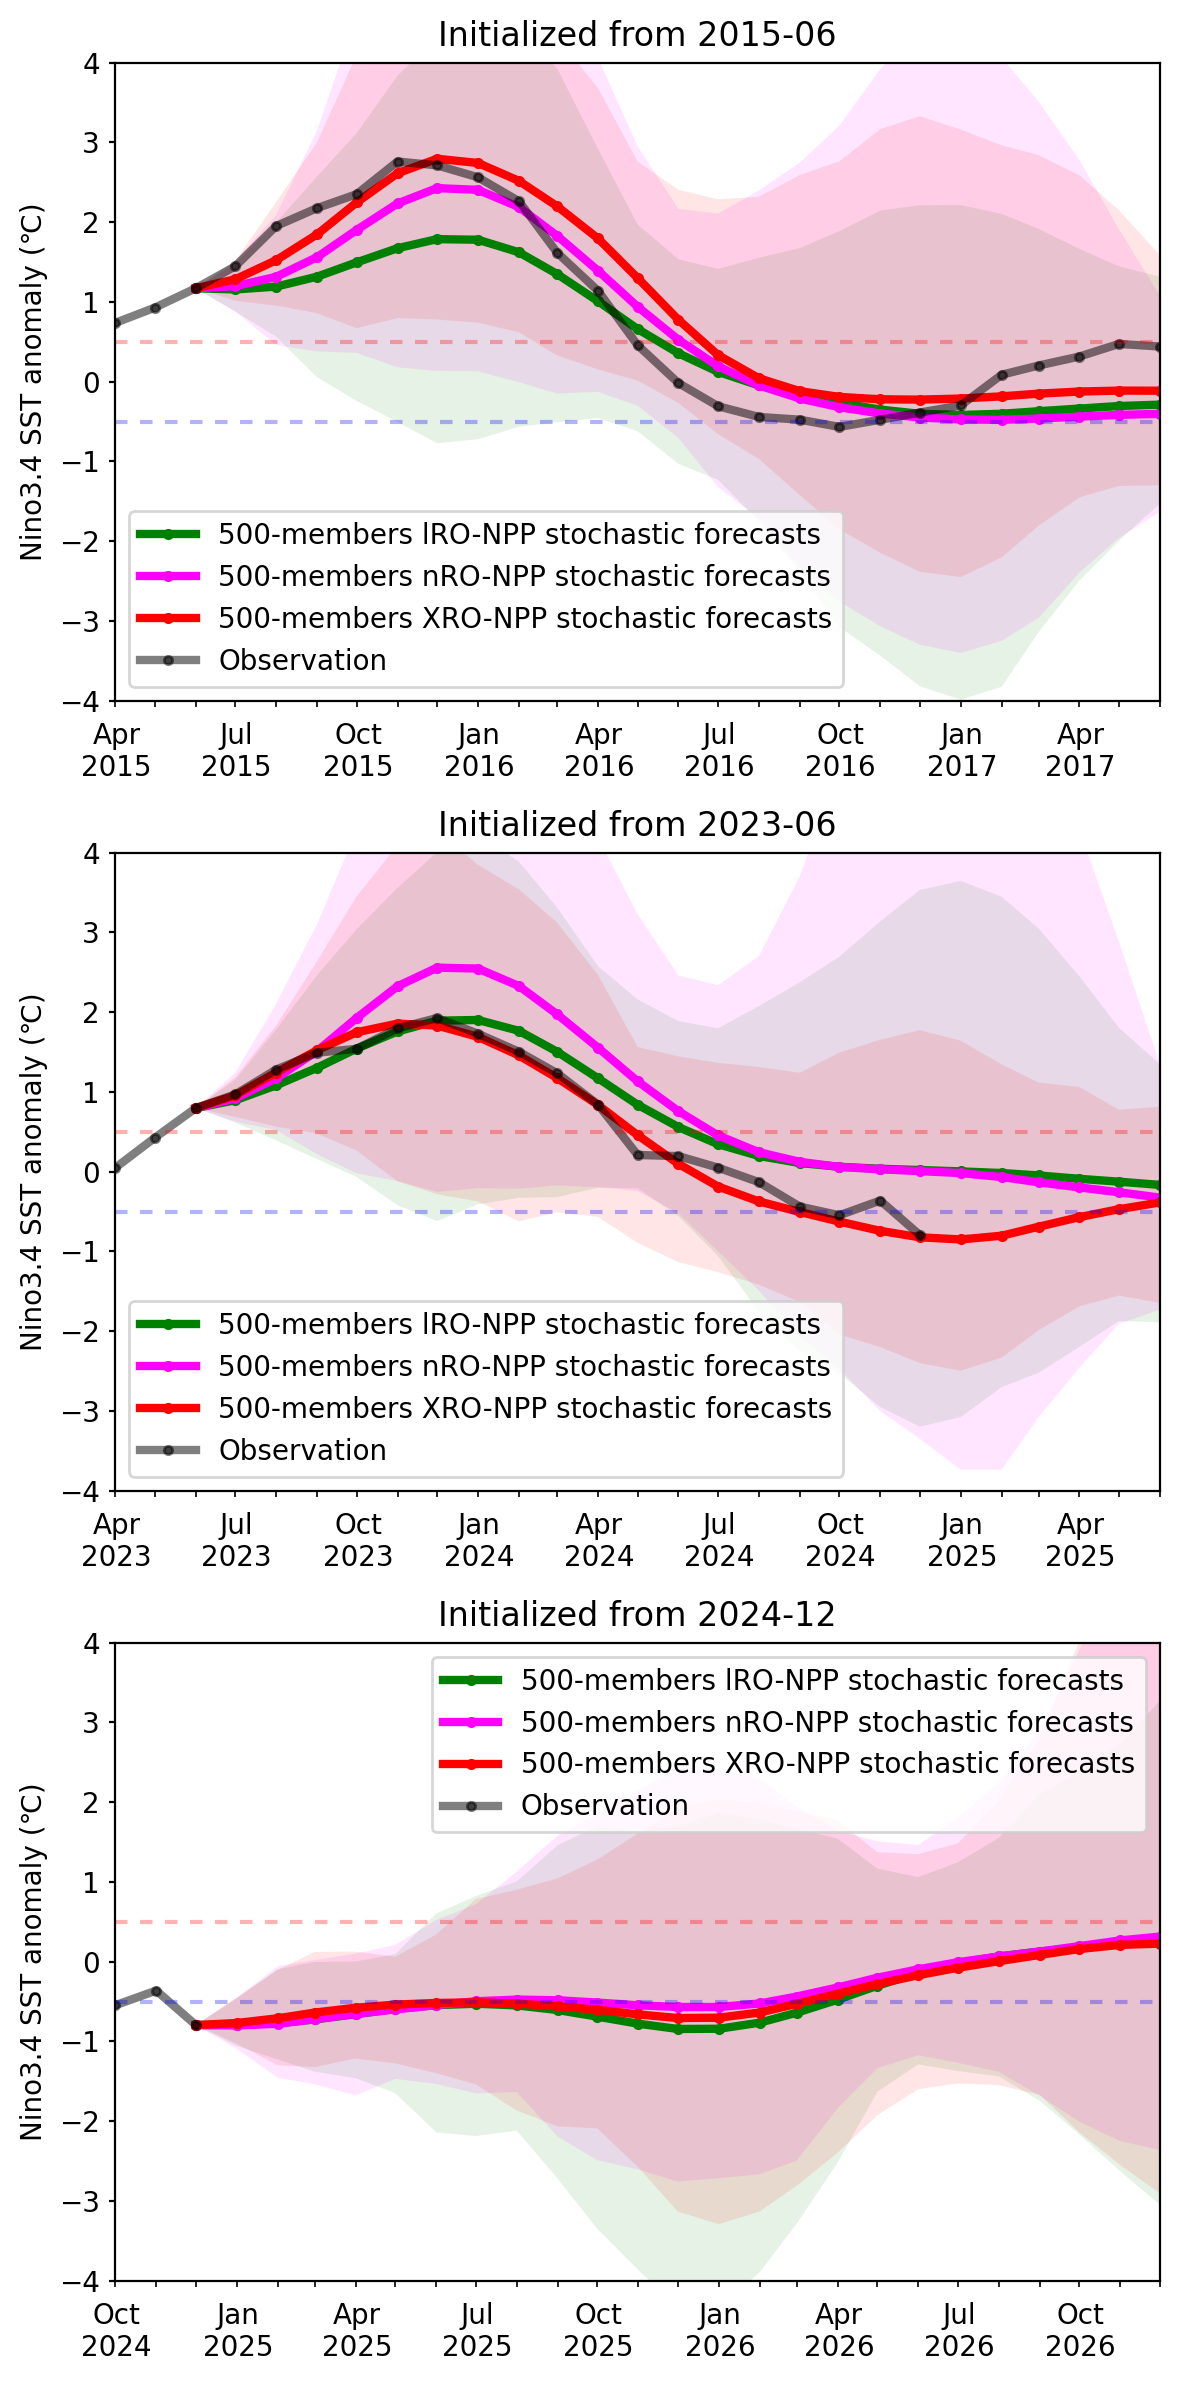

In [49]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_NPP_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_NPP_insample_fcst['Nino34'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_NPP_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_NPP_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = obs_XRO_NPP_ds['Nino34'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty

    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO-NPP stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO-NPP stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO-NPP stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([-4., 4.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()

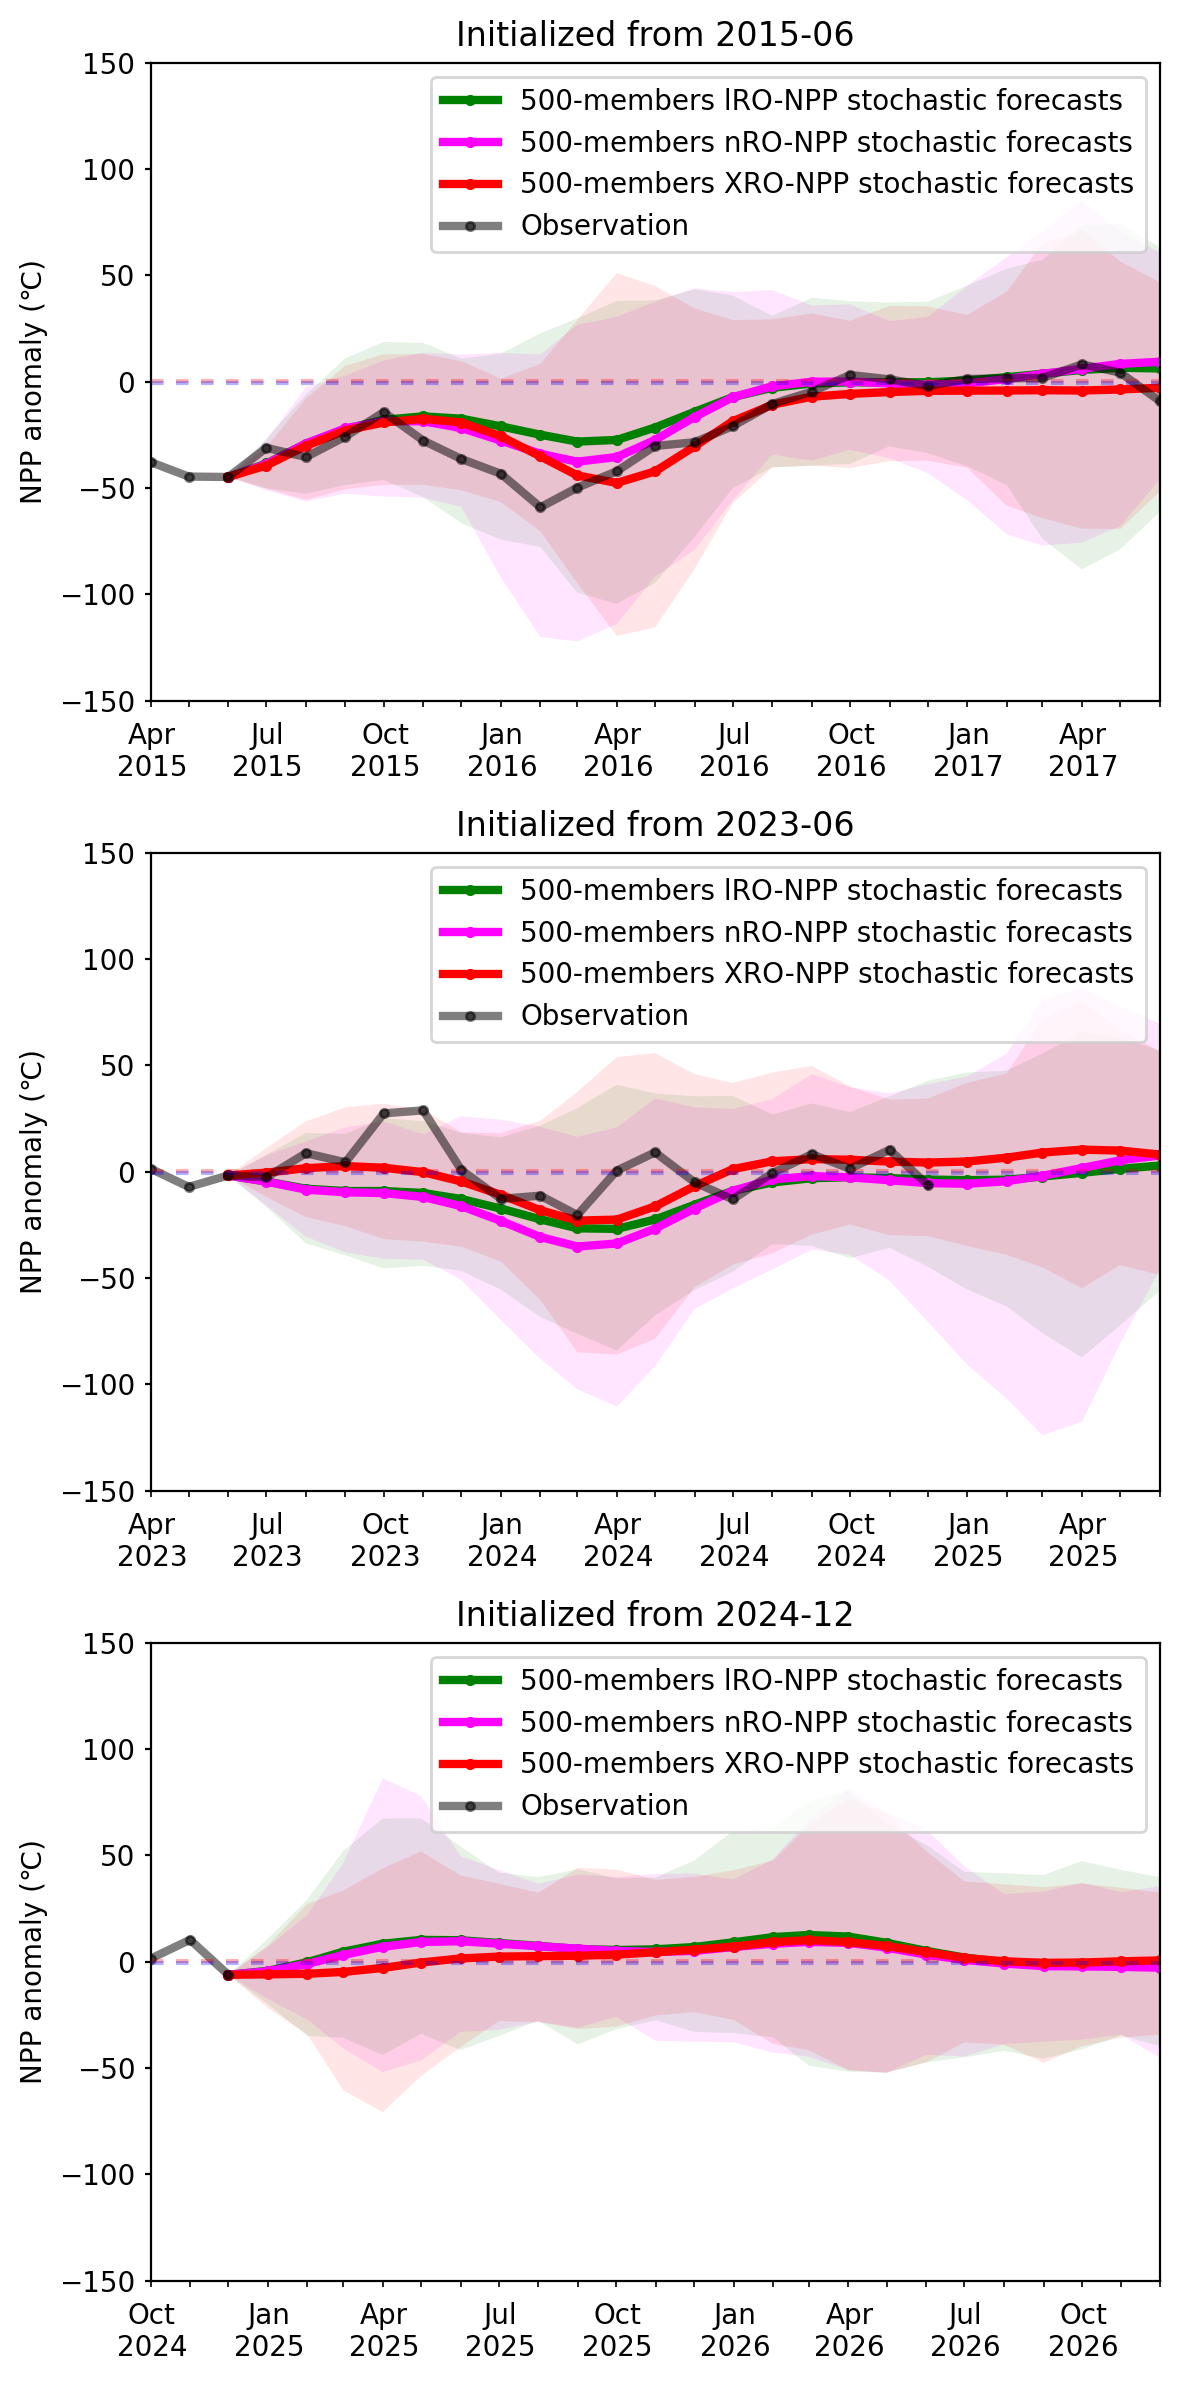

In [61]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_NPP_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_NPP_insample_fcst['NPP'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_NPP_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_NPP_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = obs_XRO_NPP_ds['NPP'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty
    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO-NPP stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO-NPP stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO-NPP stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([-150., 150.])
    ax.set_ylabel('NPP anomaly (℃)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()

In [51]:
XRO_NPP_ann_insample_fcst_ens = XRO_ann.reforecast(fit_ds=fit_XRO_NPP_ann_train, 
                                              init_ds=obs_XRO_NPP_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')

In [52]:
NRO_NPP_ann_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_NRO_NPP_ann_train, 
                                              init_ds=obs_NRO_NPP_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')

In [53]:
LRO_NPP_ann_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_LRO_NPP_ann_train, 
                                              init_ds=obs_NRO_NPP_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')

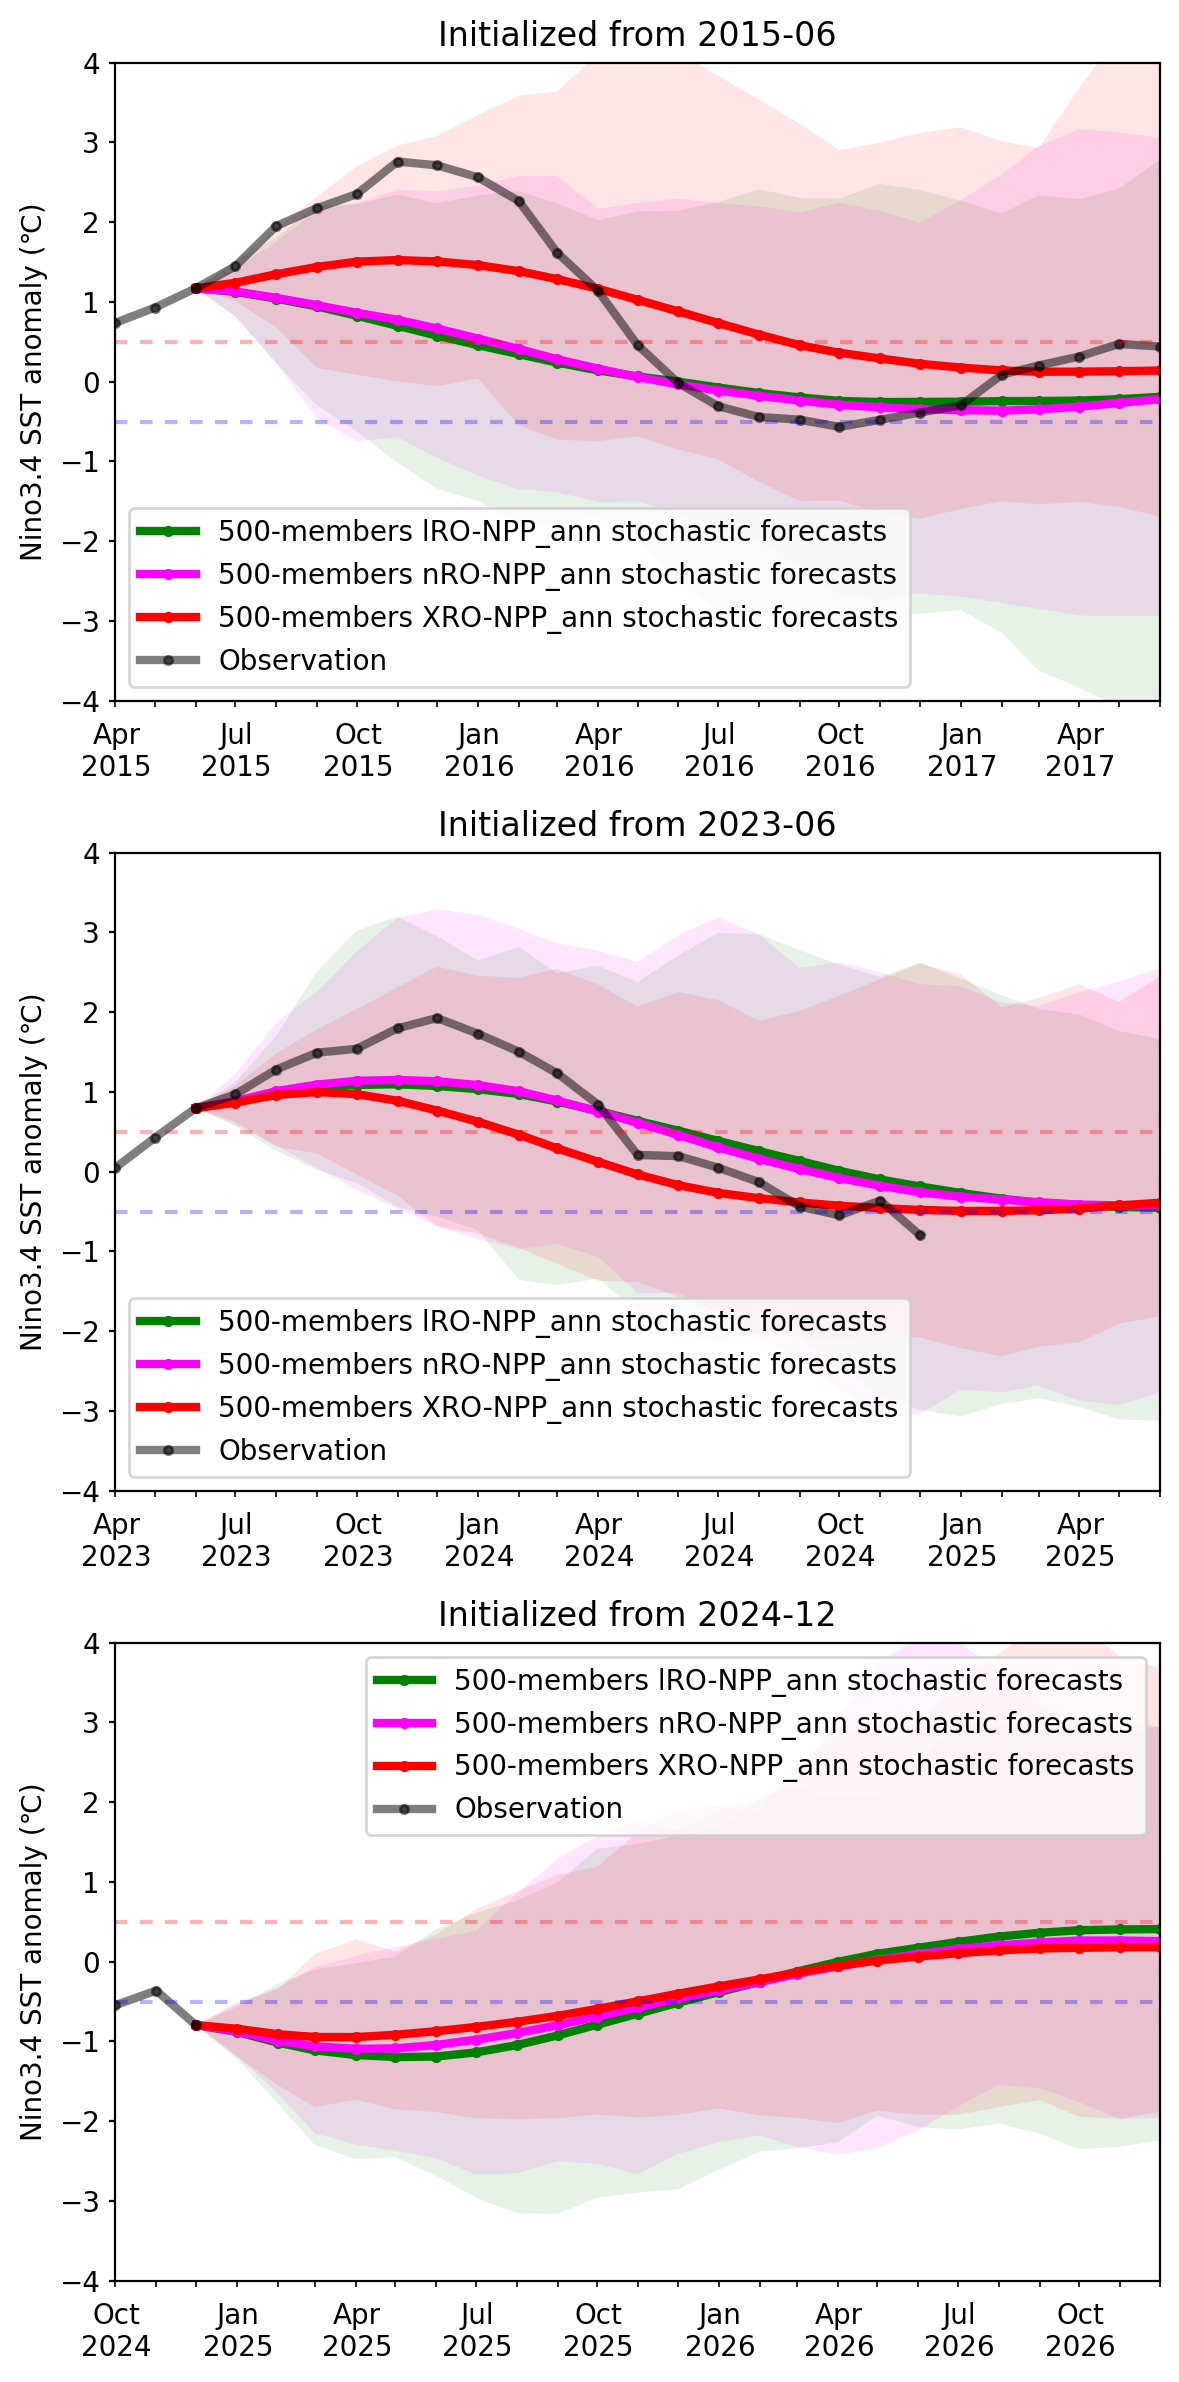

In [54]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_NPP_ann_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_NPP_ann_insample_fcst['Nino34'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_NPP_ann_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_NPP_ann_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = obs_XRO_NPP_ds['Nino34'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty

    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO-NPP_ann stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO-NPP_ann stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO-NPP_ann stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([-4., 4.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()

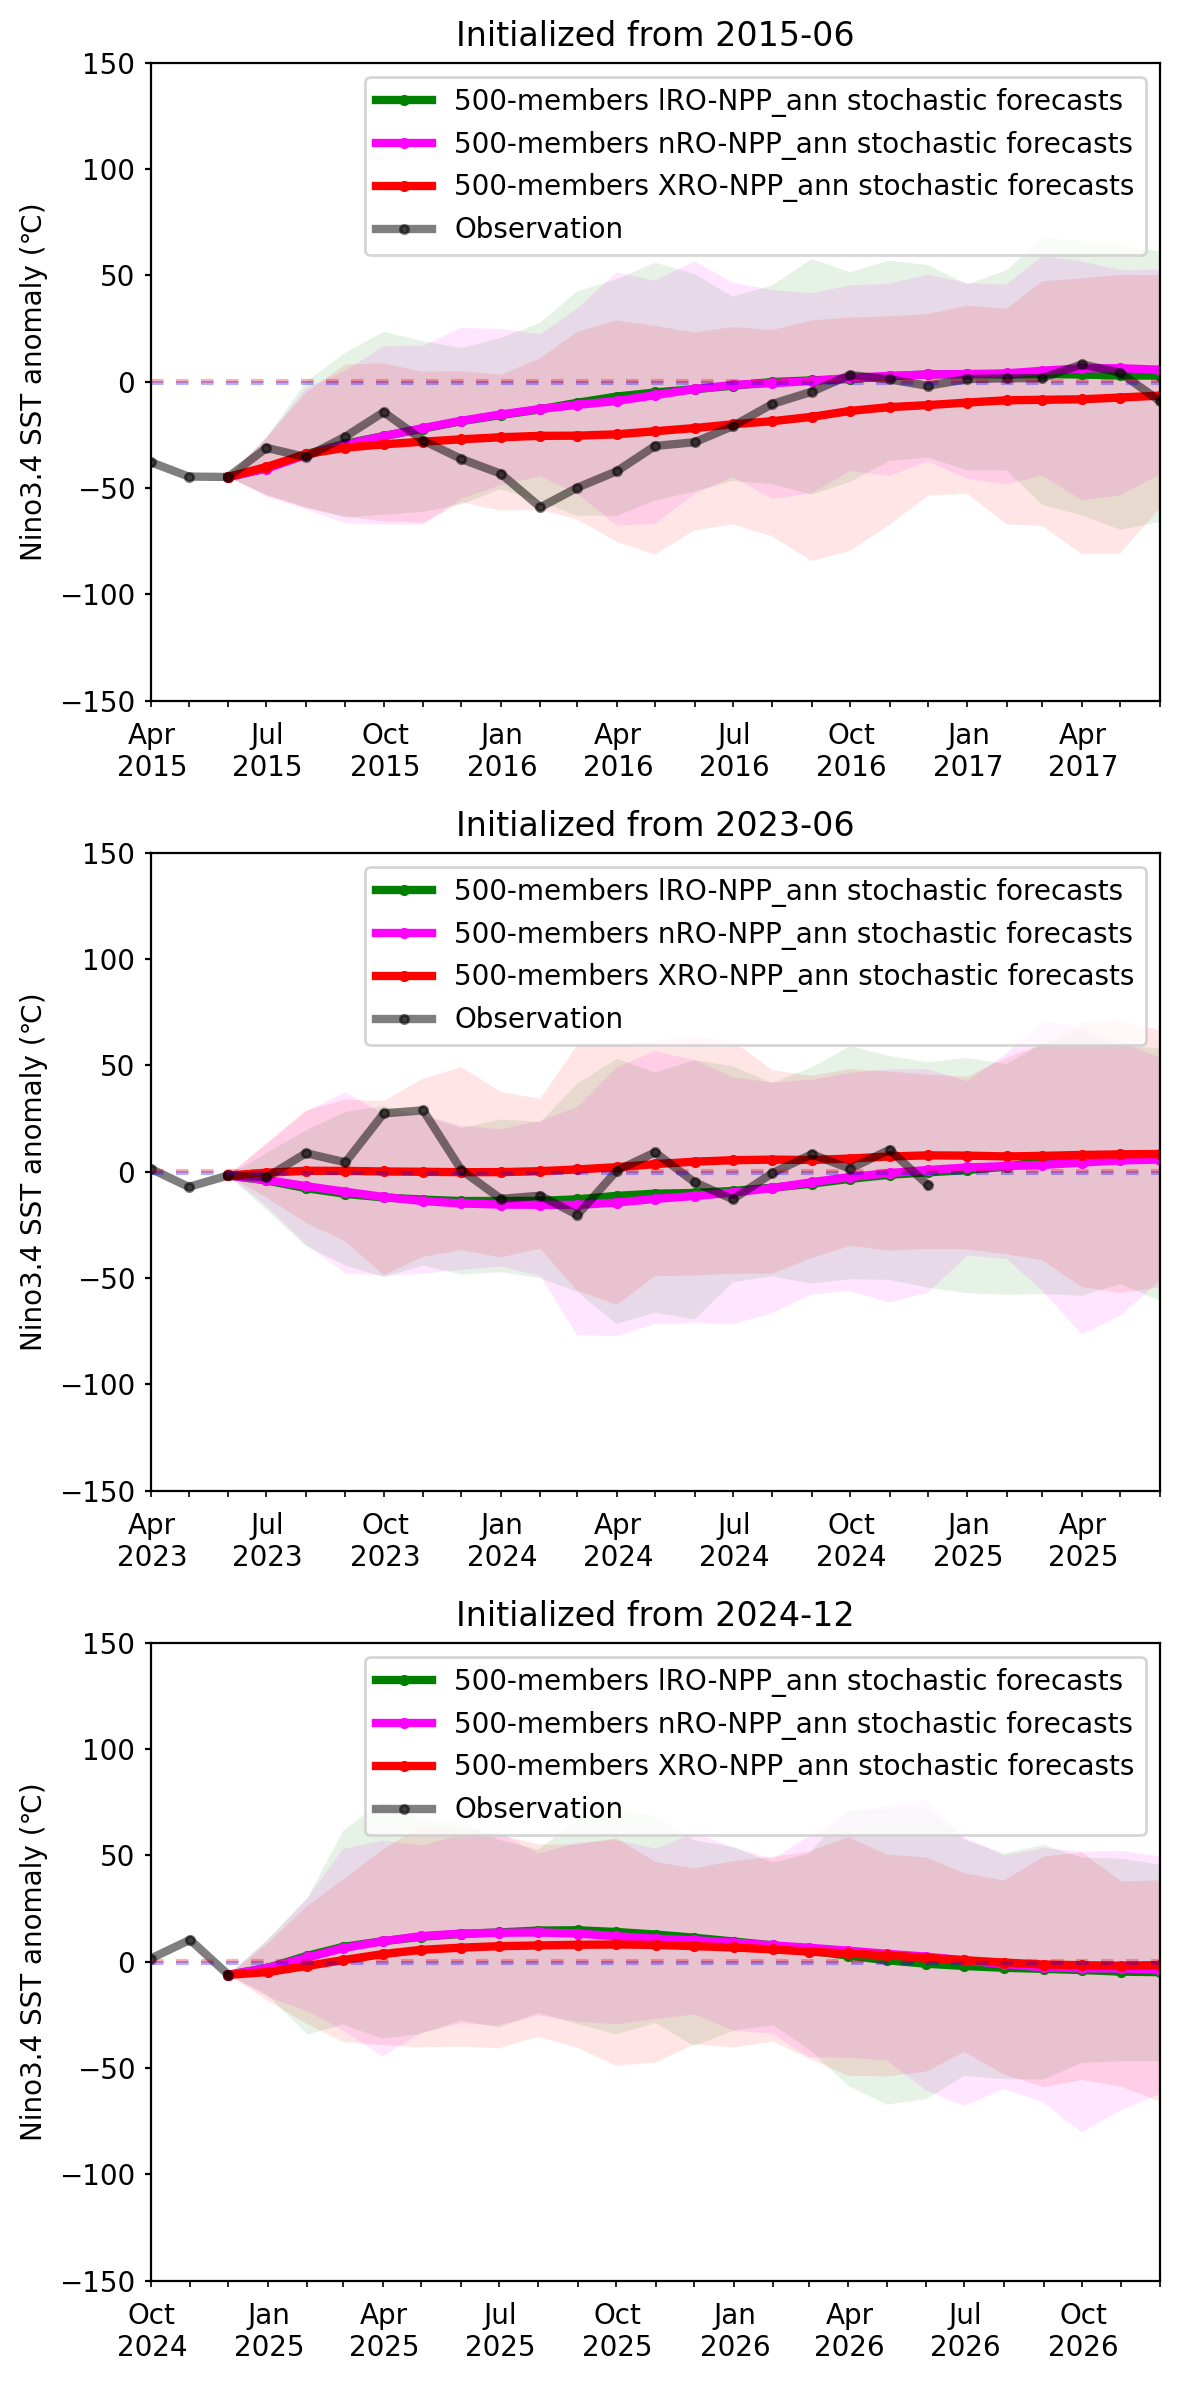

In [62]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_NPP_ann_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_NPP_ann_insample_fcst['NPP'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_NPP_ann_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_NPP_ann_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = obs_XRO_NPP_ds['NPP'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty

    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO-NPP_ann stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO-NPP_ann stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO-NPP_ann stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([-150., 150.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()

In [56]:
XRO_NPP_SST_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_XRO_NPP_SST_train, 
                                              init_ds=obs_XRO_NPP_SST_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')
NRO_NPP_SST_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_NRO_NPP_SST_train, 
                                              init_ds=obs_NRO_NPP_SST_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')
LRO_NPP_SST_insample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_LRO_NPP_SST_train, 
                                              init_ds=obs_NRO_NPP_SST_ds.sel(time=slice_verif), 
                                              n_month=24, ncopy=500, noise_type='red')

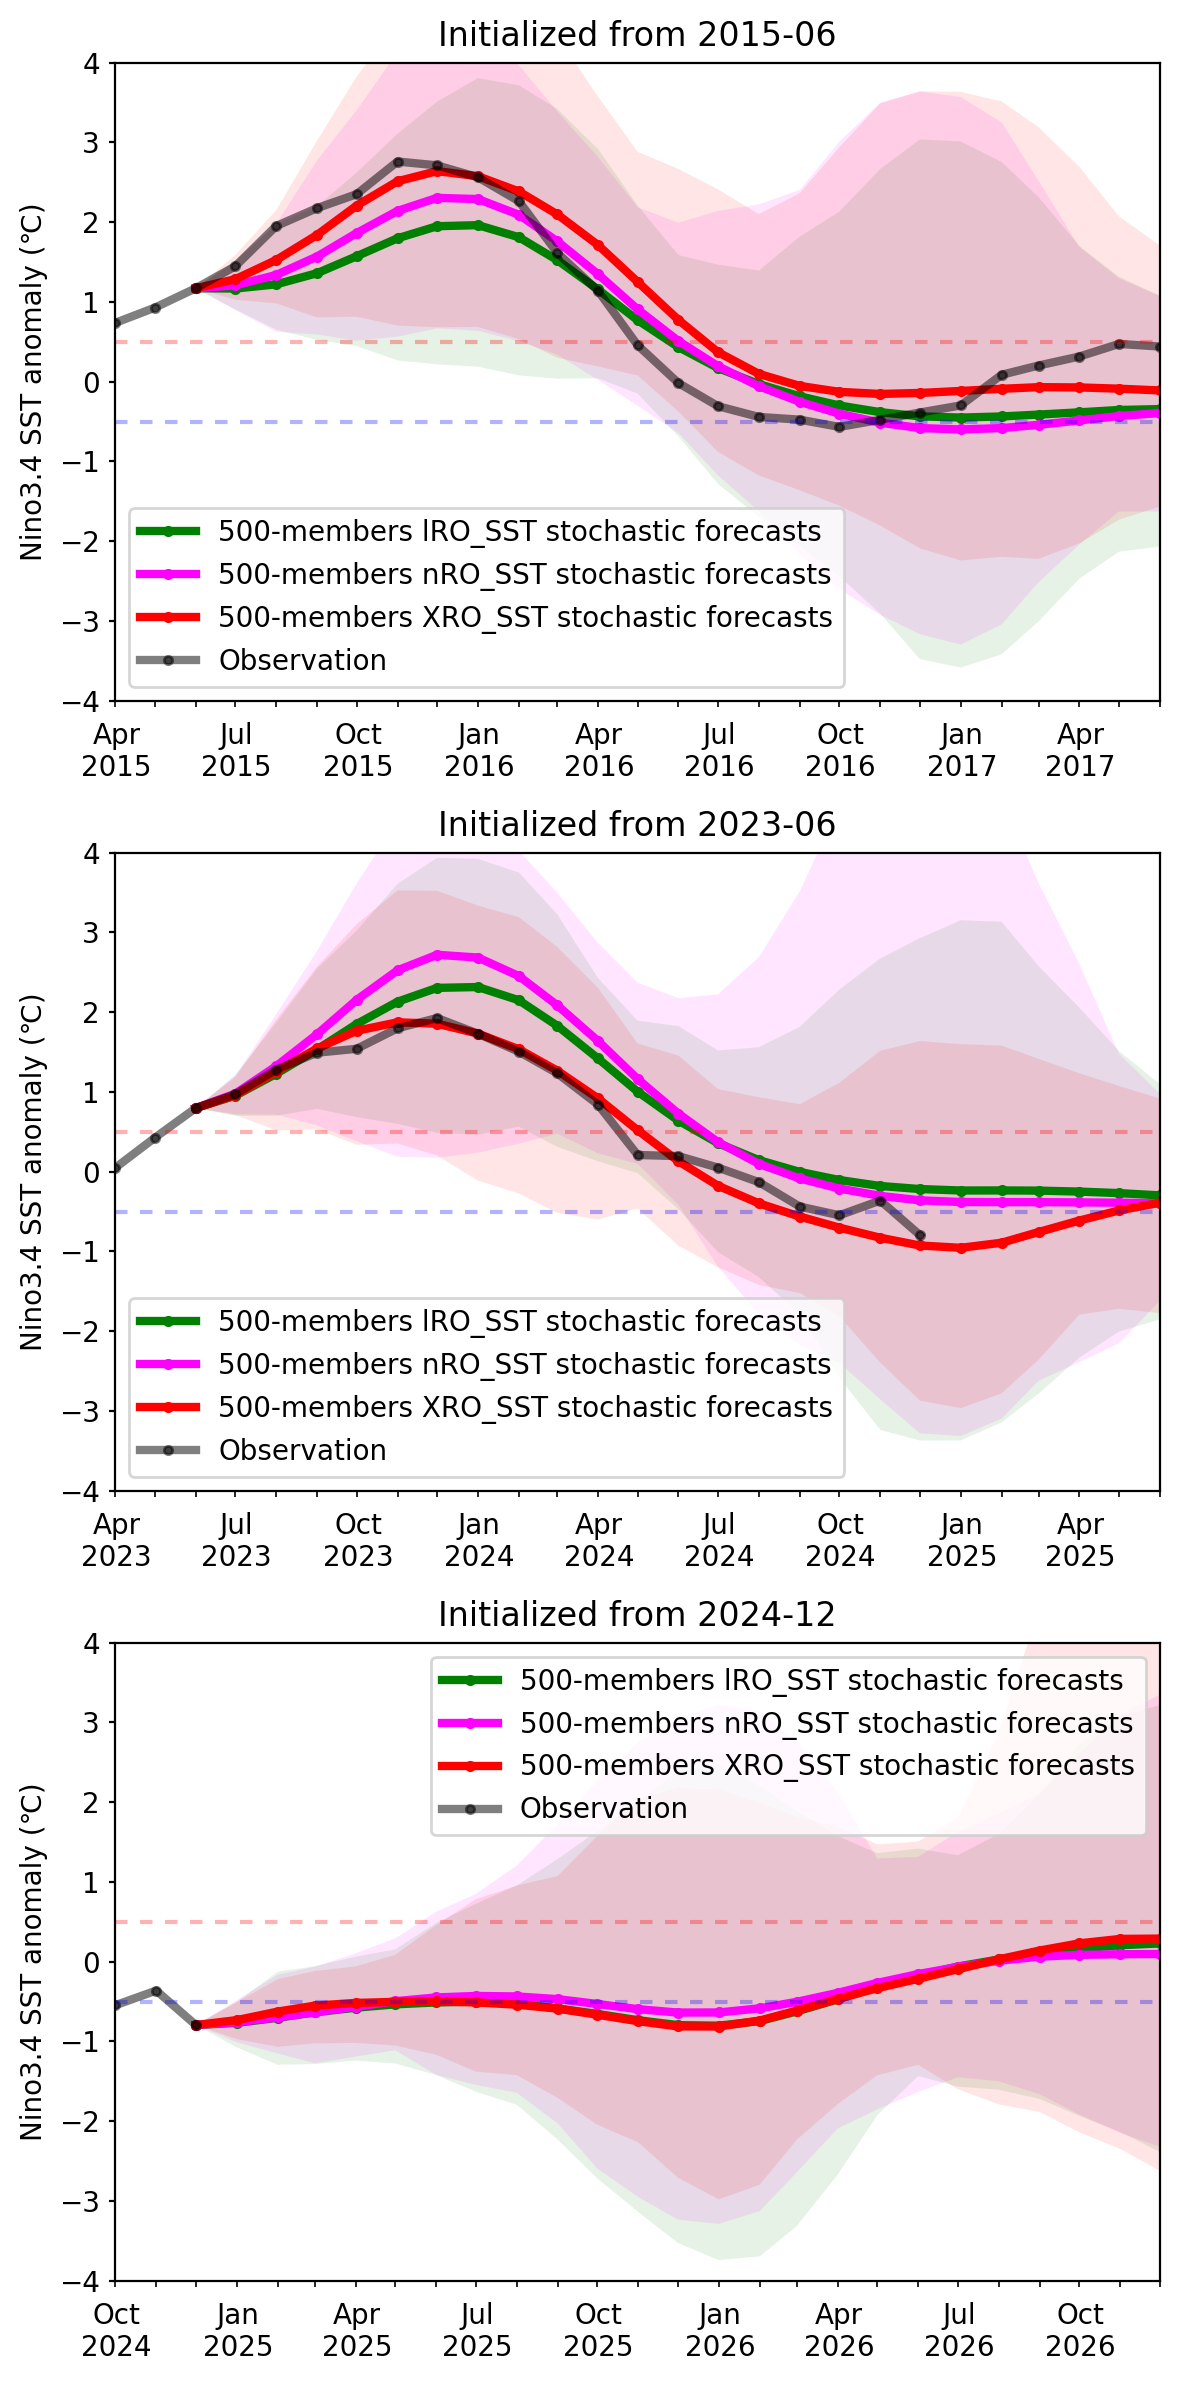

In [57]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_NPP_SST_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_NPP_SST_insample_fcst['Nino34'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_NPP_SST_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_NPP_SST_insample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = obs_XRO_NPP_SST_ds['Nino34'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty

    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO_SST stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO_SST stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO_SST stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([-4., 4.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()

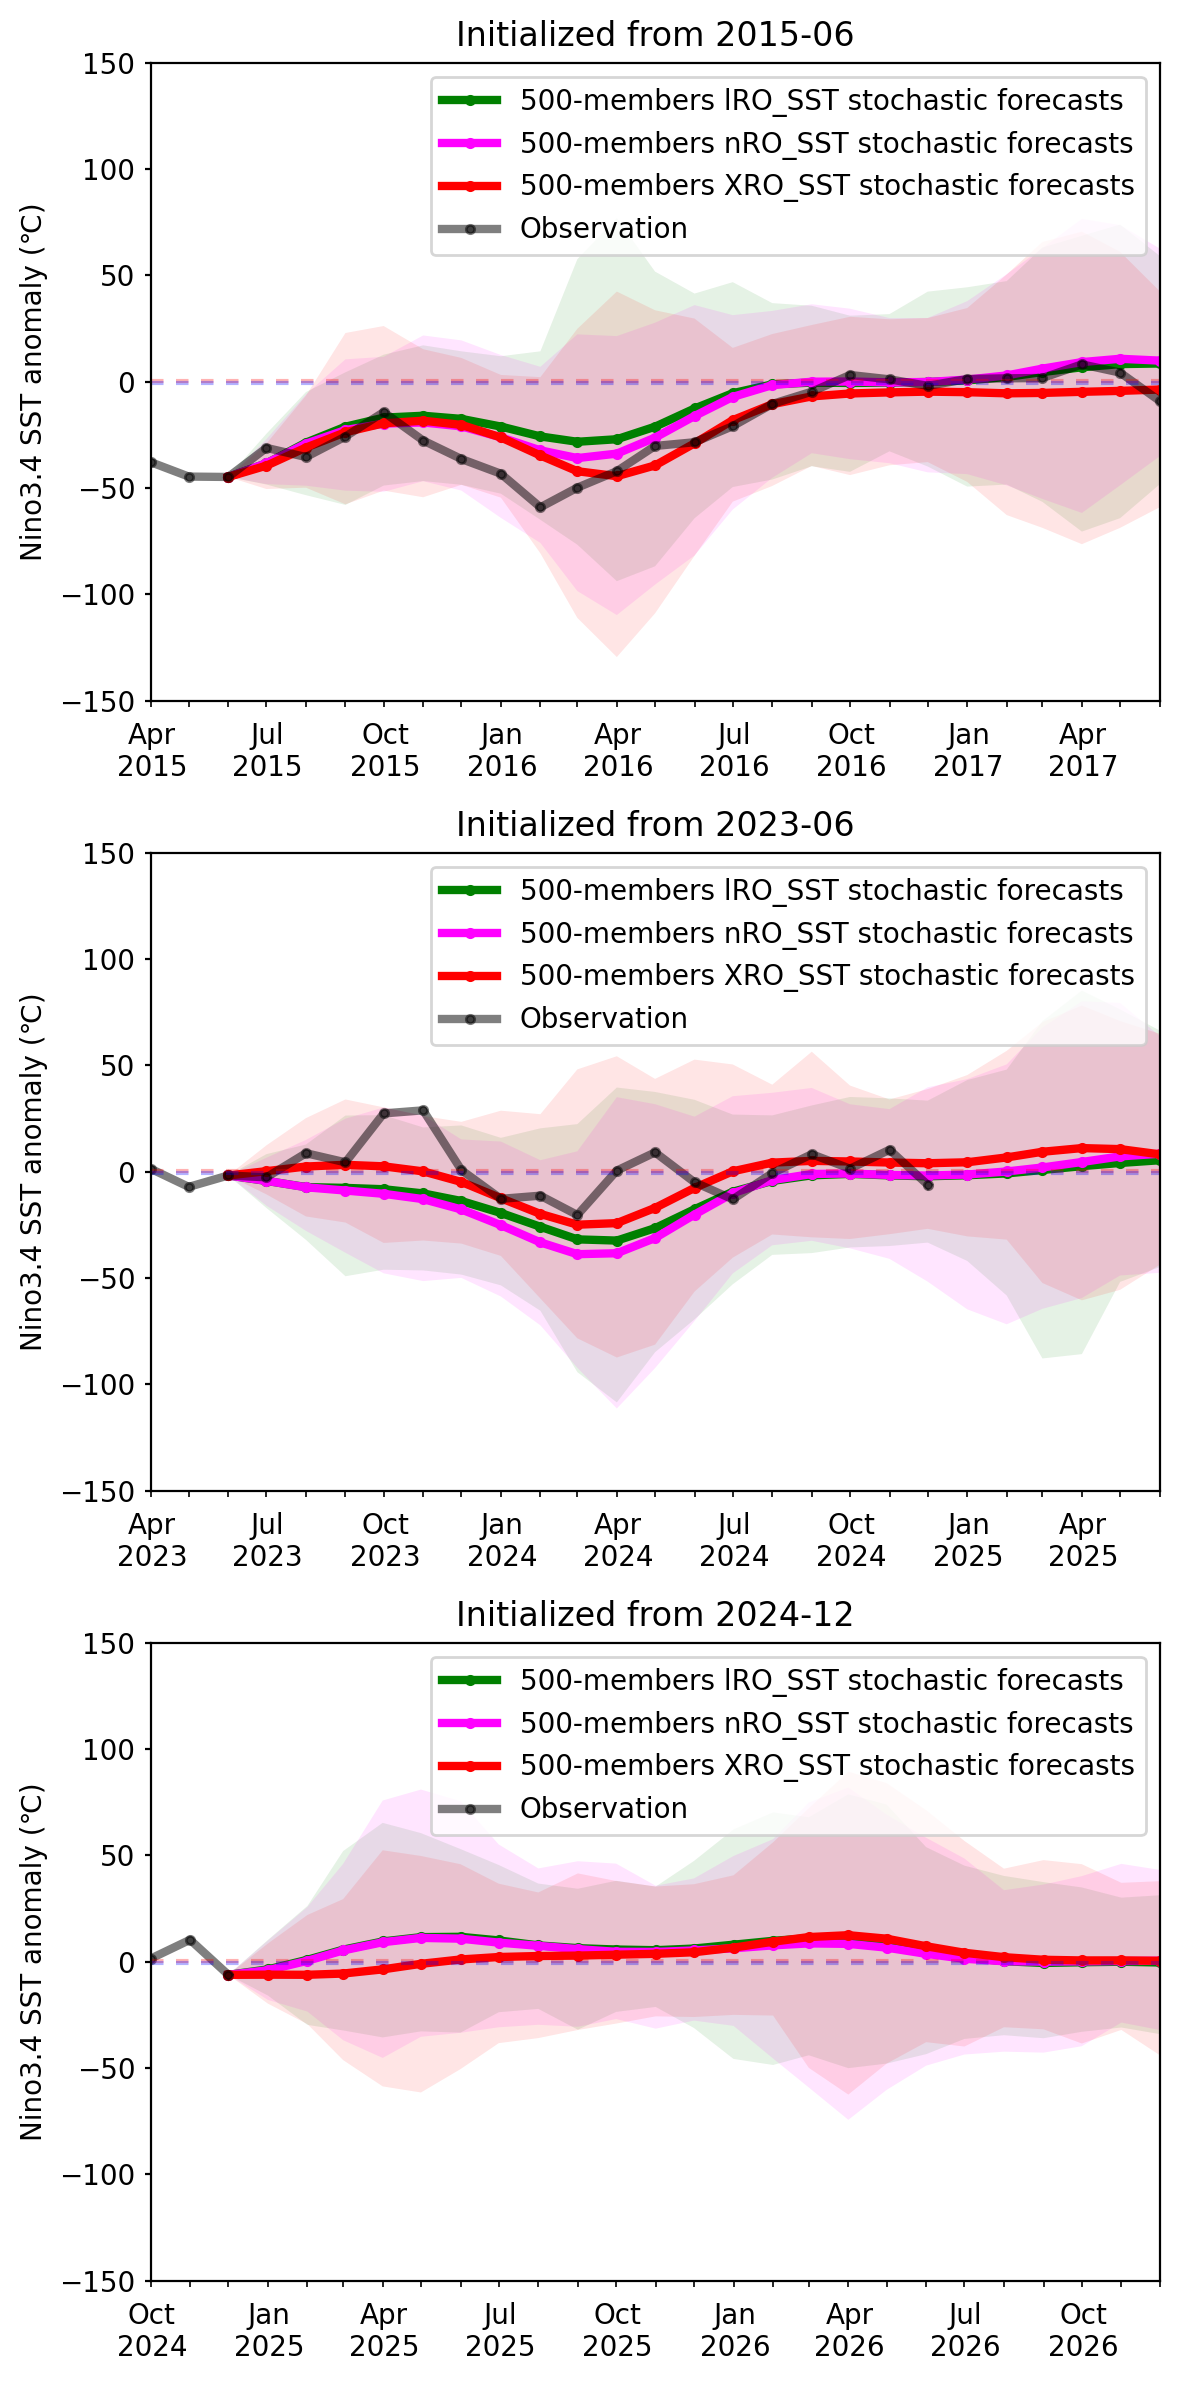

In [63]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_NPP_SST_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_NPP_SST_insample_fcst['NPP'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_NPP_SST_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()
    sel_fcstLRO_ens = LRO_NPP_SST_insample_fcst_ens['NPP'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = obs_XRO_NPP_SST_ds['NPP'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty
    # option 0.1 : 10~90%
    plot_fill_between(sel_fcstLRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='green', marker='.', lw=3, label='500-members lRO_SST stochastic forecasts', alpha=0.1, ax=ax)
    
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='magenta', marker='.', lw=3, label='500-members nRO_SST stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.0,  
                      c='red', marker='.', lw=3, label='500-members XRO_SST stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([-150., 150.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()